In [1]:
import numpy as np
import pandas as pd
import emcee
import corner
from scipy.optimize import minimize
from multiprocessing import Pool
import time
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
sn = 'ZTF18abetehf'
lc_df = pd.read_hdf("../../forced_lightcurves/mcmc_nob_ref_base/{}_force_phot.h5".format(sn))
salt_df = pd.read_csv("../../MB_SALT_020419.csv")

In [4]:
lc_df.columns

Index(['jdobs', 'filter', 'seeing', 'gain', 'zp', 'ezp', 'programid',
       'fieldid', 'ccdid', 'qid', 'filterid', 'moonra', 'moondec', 'moonillf',
       'moonphase', 'airmass', 'nbad', 'nbadbkg', 'bkgstd', 'bkgmed',
       'diffimgname', 'psfimgname', 'Fmcmc', 'Fmcmc_unc', 'Fratio',
       'Fratio_unc', 'jdref_start', 'jdref_end', 'fcqfid', 'scisigpix',
       'offset', 'multiply'],
      dtype='object')

In [5]:
lc_df.head()

jdobs filter  seeing      gain      zp       ezp  programid  \
0  2.458206e+06   b'g'   2.889  5.087996  26.325  0.000022        2.0   
1  2.458206e+06   b'g'   2.697  5.437660  26.325  0.000017        2.0   
3  2.458206e+06   b'g'   2.326  5.747641  26.325  0.000013        2.0   
4  2.458206e+06   b'g'   2.392  6.088668  26.325  0.000009        2.0   
5  2.458206e+06   b'g'   2.352  5.951111  26.325  0.000007        2.0   

   fieldid  ccdid  qid    ...          Fmcmc  Fmcmc_unc        Fratio  \
0    678.0    3.0  2.0    ...     -40.967146  74.102156 -1.209026e-09   
1    678.0    3.0  2.0    ...     -23.684265  58.034964 -6.989722e-10   
3    678.0    3.0  2.0    ...    -109.909931  45.933717 -3.243672e-09   
4    678.0    3.0  2.0    ...      55.038564  29.923475  1.624303e-09   
5    678.0    3.0  2.0    ...      -7.094775  20.467859 -2.093816e-10   

     Fratio_unc   jdref_start     jdref_end     fcqfid  scisigpix     offset  \
0  2.186910e-09  2.458167e+06  2.458205e+06  6780321.0   14.98960 -11.756764   
1  1.712733e-09  2.458167e+06  2.458205e+06  6780321.0   12.26230 -11.756764   
3  1.355600e-09  2.458167e+06  2.458205e+06  6780321.0   10.81410 -11.756764   
4  8.831044e-10  2.458167e+06  2.458205e+06  6780321.0    7.32089 -11.756764   
5  6.040493e-10  2.458167e+06  2.458205e+06  6780321.0    5.29916 -11.756764   

   multiply  
0  1.166058  
1  1.166058  
3  1.166058  
4  1.166058  
5  1.166058  

[5 rows x 32 columns]

<IPython.core.display.Javascript object>


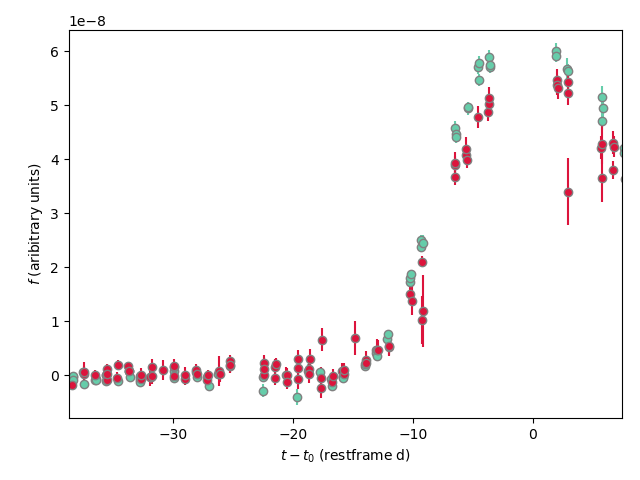

In [41]:
g_obs = np.where((lc_df['programid'] == 2.0) & 
                 (lc_df['offset'] > -999) & 
                 (lc_df['filter'] == b'g'))
r_obs = np.where((lc_df['programid'] == 2.0) & 
                 (lc_df['offset'] > -999) & 
                 (lc_df['filter'] == b'r'))
obs = np.where( (lc_df['programid'] == 2.0) & 
                (lc_df['offset'] > -999)  
              )

t0 = float(salt_df['t0'][salt_df['sn'] == sn].values) + 2400000.5
z = float(salt_df['z'][salt_df['sn'] == sn].values)

fig, ax = plt.subplots()
ax.errorbar((lc_df['jdobs'].iloc[g_obs] - t0)/(1+z), 
            lc_df['Fratio'].iloc[g_obs],
            lc_df['Fratio_unc'].iloc[g_obs], 
            fmt = 'o', color='MediumAquaMarine',
            mec='0.5')
ax.errorbar((lc_df['jdobs'].iloc[r_obs] - t0)/(1+z), 
            lc_df['Fratio'].iloc[r_obs],
            lc_df['Fratio_unc'].iloc[r_obs], 
            fmt = 'o', color='Crimson',
            mec='0.5')
ax.set_xlabel('$t - t_0 \; (\mathrm{restframe \; d})$')
ax.set_ylabel('$f \; (\mathrm{aribitrary \; units})$')
fig.tight_layout()

In [7]:
def f_t(times, baseline=0, h_1=25, t_1=0, alpha_1=2, h_2=25, t_2=3, alpha_2=2):
    
    flux = np.empty_like(times)
    pre_exp = np.where(times < t_1)
    pre_break = np.where((times >= t_1) & (times < t_2))
    post_break = np.where((times >= t_2))
    flux[pre_exp] = baseline
    flux[pre_break] = baseline + h_1*(times[pre_break] - t_1)**alpha_1
    flux[post_break] = baseline + h_1*(times[post_break] - t_1)**alpha_1 + h_2*(times[post_break] - t_2)**alpha_2
    
    return flux

In [13]:
def plot_model(t, f, f_unc, theta, flux_cut=0.5):
    half_max = np.where((f < flux_cut) & (t < 0))
    
    t_grid = np.linspace(min(t), max(t), 1000)
    model_flux = f_t(t_grid, theta[0], theta[1], theta[2], theta[3], theta[4], theta[5], theta[6])
    fig = plt.figure()
    axPlot = plt.axes([0.15, 0.37, 0.84, 0.61])
    axRes = plt.axes([0.15, 0.1, 0.84, 0.25], sharex=axPlot)
    axPlot.errorbar(t, f, f_unc,
                fmt = 'o', color='MediumAquaMarine',
                mec='0.5')
    axPlot.plot(t_grid, model_flux, 'k', zorder=10)
    axPlot.plot([max(t[half_max]),max(t[half_max])], [-50,50], 
               '--', color='DarkOrange')
    axPlot.plot([theta[2],theta[2]], [-50,50], 
               '--', color='0.8',lw=0.5)
    axPlot.plot([theta[5],theta[5]], [-50,50], 
               '--', color='0.8',lw=0.5)
    axPlot.set_xlim(min(t), 3)
    axPlot.set_ylim(min(f), 1.1)

    after_exp = t >= theta[0]
    
    residuals = f - f_t(t, theta[0], theta[1], theta[2], theta[3], theta[4], theta[5], theta[6])
    
    axRes.errorbar(t, residuals, f_unc,
                   fmt = 'o', color='MediumAquaMarine',
                   mec='0.5')
    axRes.plot([-5000,10000], [0,0], 'k--')
    axRes.plot([max(t[half_max]),max(t[half_max])], [-50,50], 
               '--', color='DarkOrange')
    axRes.set_xlim(min(t), 3)

    res_amp = max(residuals[half_max]) - min(residuals[half_max])
    axRes.set_ylim(min(residuals[half_max])-0.1*res_amp, max(residuals[half_max])+0.1*res_amp)
    axRes.set_xlabel('$t - t_0 \; (\mathrm{restframe \; d})$')
    axPlot.set_ylabel('$f \; (\mathrm{aribitrary \; units})$')
#     fig.tight_layout()
    
    return

In [53]:
def lnlike_simple(theta, f, t, f_err):
    baseline, h_1, t_1, alpha_1, h_2, t_2, alpha_2 = theta
    
    model = f_t(t, baseline=theta[0], 
                h_1=theta[1], t_1=theta[2], alpha_1=theta[3], 
                h_2=theta[4], t_2=theta[5], alpha_2=theta[6])
        
    ln_l = -0.5*np.sum((f - model)**2 / (f_err**2))
    return ln_l

def nll_simple(theta, f, t, f_err):
    return -1*lnlike_simple(theta, f, t, f_err)

#Define priors on parameters  
def lnprior_simple(theta):
    baseline, h_1, t_1, alpha_1, h_2, t_2, alpha_2 = theta
    if (-1e8 < baseline < 1e8 and 
        -30 < t_1 < 0 and 
        -1e8 < t_2 < -10 and 
        0 < h_1 < 1e8 and 
        0 < alpha_1 < 1e8 and 
        0 < h_2 < 1e8 and 
        0 < alpha_2 < 1e8 and
        t_1 < t_2):
        return 0.0
    return -np.inf

def lnposterior_simple(theta, f, t, f_err):
    lnp = lnprior_simple(theta)
    lnl = lnlike_simple(theta, f, t, f_err)
    if not np.isfinite(lnl):
        return -np.inf
    if not np.isfinite(lnp):
        return -np.inf
    return lnl + lnp

In [66]:
time_jd = (lc_df['jdobs'].iloc[r_obs].values - t0)/(1+z)
max_flux = np.max(lc_df['Fratio'].iloc[r_obs].values)
# normalize flux as units are arbitrary and 
# we marginalize over the amplitude anyway
flux = lc_df['Fratio'].iloc[r_obs].values/max_flux
flux_unc = lc_df['Fratio_unc'].iloc[r_obs].values/max_flux
t_fl = 17

guess_0 = np.array([0, 2e-2, -t_fl, 1, 1e-2, 3-t_fl, 1.8])

flux_cut = 0.5
half_max = np.where((flux < flux_cut) & (time_jd < 0))
f_data = flux[half_max]
t_data = time_jd[half_max]
f_unc_data = flux_unc[half_max]

In [67]:
# initialize near maximum-likelihood result
ml_res = minimize(nll_simple, guess_0, method='Powell', # Powell method does not need derivatives
                  args=(f_data, t_data, f_unc_data))
ml_guess = ml_res.x
print(ml_guess)
print(nll_simple(ml_guess, f_data, t_data, f_unc_data))

[ 6.00111052e-03  1.76031429e-02 -1.64371887e+01  9.97271352e-01
  1.27768764e-02 -1.34512887e+01  2.03832227e+00]
71.11117618827242


<IPython.core.display.Javascript object>


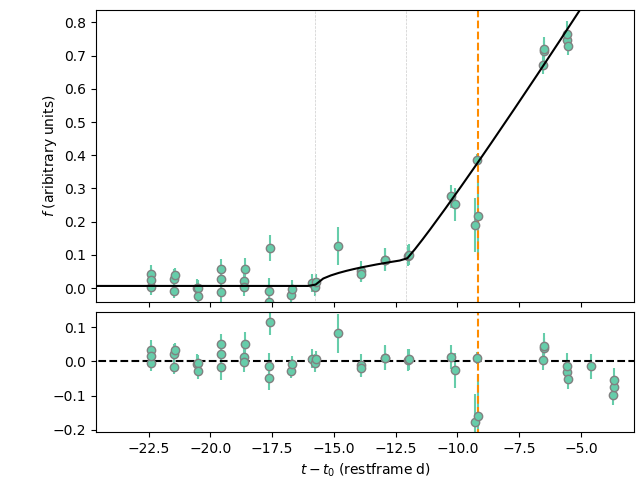

In [71]:
plot_model(time_jd, flux, flux_unc,
           [ 6.23459655e-03,  4.03333346e-02, -1.57546034e+01,  5.20796118e-01,
        8.26617624e-02, -1.20812877e+01,  1.08884933e+00], flux_cut=flux_cut)

In [69]:
###################################
###  sample without sig_0 term  ###
###################################


nwalkers = 150
ndim = len(ml_guess)
nfac = [1e-3]*ndim

#initial position of walkers
pos = [ml_guess + ml_guess * nfac * np.random.randn(ndim) for i in range(nwalkers)]
# pos = [[-16.7, 0, 0.01, 2] + nfac * np.random.randn(ndim) for i in range(nwalkers)]

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior_simple, 
                                    args=(f_data, t_data, f_unc_data),
                                    pool=pool)
    max_samples = 100000
    index = 0
    autocorr = np.empty(max_samples)
    old_tau = np.inf
    check_tau = 2500
    for sample in sampler.sample(pos, iterations=max_samples, progress=True):
        if sampler.iteration % check_tau:
            continue
        
        tstart = time.time()
        tau = sampler.get_autocorr_time(tol=0)
        tend = time.time()
        autocorr[index] = np.mean(tau)
        index += 1
        steps_so_far = index*check_tau
        print('''After {:d} steps, 
autocorrelation takes {:.3f} s ({} total FFTs)                
acceptance fraction = {:.4f}, and
tau = {}'''.format(steps_so_far, 
                   tend-tstart, nwalkers*ndim,
                   np.mean(sampler.acceptance_fraction), 
                   tau))

        # Check convergence
        converged = np.all(tau * 100 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau

  0%|          | 0/100000 [00:00<?, ?it/s]/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
  0%|          | 14/100000 [00:00<12:22, 134.71it/s]/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/e

After 2500 steps, 
autocorrelation takes 0.241 s (1050 total FFTs)                
acceptance fraction = 0.1948, and
tau = [164.78185584 199.82917286 179.73661504 209.58837764 252.98028885
 245.9580089  256.92264979]


  5%|▌         | 5019/100000 [00:31<17:07, 92.45it/s] 

After 5000 steps, 
autocorrelation takes 0.334 s (1050 total FFTs)                
acceptance fraction = 0.1961, and
tau = [245.17388377 344.34735383 307.61661872 353.51947819 402.9479543
 389.5364689  413.01953442]


  8%|▊         | 7515/100000 [00:47<20:46, 74.21it/s] 

After 7500 steps, 
autocorrelation takes 0.359 s (1050 total FFTs)                
acceptance fraction = 0.1969, and
tau = [303.37486784 483.55751787 421.93588877 482.53372814 525.95195031
 548.15126732 588.91579247]


  9%|▉         | 8831/100000 [00:55<09:08, 166.29it/s]/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
  9%|▉         | 8949/100000 [00:56<09:38, 157.29it/s]/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
  9%|▉         | 8982/100000 [00:56<09:46, 155.31it/s]/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
  9%|▉         | 9030/100000 [00:56<09:50, 154.03it/s]/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
  9%|▉         | 9065/100000 [00:5

After 10000 steps, 
autocorrelation takes 0.620 s (1050 total FFTs)                
acceptance fraction = 0.1880, and
tau = [341.22697593 583.13668258 551.6652763  606.38740474 609.80030612
 712.36780525 655.68651607]


 10%|█         | 10031/100000 [01:03<18:06, 82.82it/s]/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':
 10%|█         | 10097/100000 [01:03<11:27, 130.74it/s]/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in true_divide
  
 10%|█         | 10113/100000 [01:03<10:59, 136.40it/s]/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in true_divide
  
 10%|█         | 10204/100000 [01:04<10:49, 138.29it/s]/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in true_divide
  
 10%|█         | 10219/100000 [01:04<10:52, 137.58it/s]/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeW

After 12500 steps, 
autocorrelation takes 0.659 s (1050 total FFTs)                
acceptance fraction = 0.1754, and
tau = [414.08927809 714.26227594 700.39129757 833.3947726  594.01589883
 979.63895445 609.9958211 ]


 15%|█▌        | 15019/100000 [01:42<32:23, 43.74it/s] 

After 15000 steps, 
autocorrelation takes 0.808 s (1050 total FFTs)                
acceptance fraction = 0.1653, and
tau = [ 474.28788099  880.58970972  890.01151536 1090.62256554  694.13096239
 1305.49215121  992.20504688]


 18%|█▊        | 17516/100000 [02:03<38:20, 35.85it/s] 

After 17500 steps, 
autocorrelation takes 1.245 s (1050 total FFTs)                
acceptance fraction = 0.1576, and
tau = [ 519.9707013  1026.5963872  1043.56832674 1392.48377131 1205.67387685
 1642.55782883 1535.12612214]


 20%|██        | 20015/100000 [02:20<28:33, 46.68it/s] 

After 20000 steps, 
autocorrelation takes 1.112 s (1050 total FFTs)                
acceptance fraction = 0.1529, and
tau = [ 543.17726304 1153.10528279 1151.00240372 1692.18246956 1757.76329541
 1946.48562559 1953.20497307]


 23%|██▎       | 22514/100000 [02:37<36:33, 35.32it/s] 

After 22500 steps, 
autocorrelation takes 1.156 s (1050 total FFTs)                
acceptance fraction = 0.1497, and
tau = [ 577.31795588 1319.22873615 1266.94787099 2018.13735828 2261.16543116
 2223.7768012  2318.4537839 ]


 25%|██▌       | 25016/100000 [02:54<35:31, 35.17it/s] 

After 25000 steps, 
autocorrelation takes 1.250 s (1050 total FFTs)                
acceptance fraction = 0.1464, and
tau = [ 595.82844306 1552.57576973 1434.72993986 2371.78167643 2626.44043073
 2505.53257649 2615.59305246]


 28%|██▊       | 27517/100000 [03:12<29:23, 41.10it/s] 

After 27500 steps, 
autocorrelation takes 1.325 s (1050 total FFTs)                
acceptance fraction = 0.1438, and
tau = [ 647.92922975 1790.72864262 1561.38065262 2717.29984309 2943.10513865
 2801.75569594 2915.67347093]


 30%|███       | 30024/100000 [03:30<33:46, 34.54it/s] 

After 30000 steps, 
autocorrelation takes 1.532 s (1050 total FFTs)                
acceptance fraction = 0.1412, and
tau = [ 688.27327004 2003.90453815 1693.83129422 3030.48119013 3199.43902743
 3092.08133835 3180.67852076]


 33%|███▎      | 32515/100000 [03:49<34:00, 33.07it/s] 

After 32500 steps, 
autocorrelation takes 1.597 s (1050 total FFTs)                
acceptance fraction = 0.1394, and
tau = [ 714.02986306 2200.01452788 1795.83360508 3322.67464567 3483.57569969
 3377.46887918 3439.57090491]


 35%|███▌      | 35014/100000 [04:09<57:26, 18.85it/s] 

After 35000 steps, 
autocorrelation takes 2.299 s (1050 total FFTs)                
acceptance fraction = 0.1380, and
tau = [ 739.2080829  2370.75005565 1873.21718275 3589.19806097 3733.78496798
 3645.89639099 3659.81949252]


 38%|███▊      | 37522/100000 [04:28<39:25, 26.42it/s] 

After 37500 steps, 
autocorrelation takes 2.359 s (1050 total FFTs)                
acceptance fraction = 0.1371, and
tau = [ 774.19906142 2521.32445567 1983.16282335 3820.74745527 3976.228246
 3892.7612305  3864.8960184 ]


 40%|████      | 40022/100000 [04:46<37:56, 26.34it/s] 

After 40000 steps, 
autocorrelation takes 2.384 s (1050 total FFTs)                
acceptance fraction = 0.1363, and
tau = [ 785.67986398 2645.27051918 2082.75700044 4024.29819177 4183.03708545
 4125.79071723 4054.53606064]


 43%|████▎     | 42514/100000 [05:05<38:32, 24.86it/s] 

After 42500 steps, 
autocorrelation takes 2.370 s (1050 total FFTs)                
acceptance fraction = 0.1361, and
tau = [ 805.01814562 2776.61008887 2175.01940025 4248.09464649 4395.61056418
 4354.52909974 4236.04064697]


 45%|████▌     | 45024/100000 [05:24<41:27, 22.10it/s] 

After 45000 steps, 
autocorrelation takes 2.704 s (1050 total FFTs)                
acceptance fraction = 0.1359, and
tau = [ 823.9020745  2882.94402533 2239.1031777  4468.57086703 4589.68329952
 4576.42323944 4396.52409291]


 48%|████▊     | 47520/100000 [05:44<47:16, 18.50it/s]  

After 47500 steps, 
autocorrelation takes 2.844 s (1050 total FFTs)                
acceptance fraction = 0.1353, and
tau = [ 842.37297347 2966.25922467 2300.62079745 4663.83046255 4783.13216812
 4792.09241082 4593.67967778]


 50%|█████     | 50015/100000 [06:04<40:33, 20.54it/s] 

After 50000 steps, 
autocorrelation takes 2.948 s (1050 total FFTs)                
acceptance fraction = 0.1354, and
tau = [ 850.18877007 3033.47151147 2373.10828918 4830.10228684 4973.98221712
 4999.30644773 4754.65335309]


 53%|█████▎    | 52522/100000 [06:24<35:20, 22.39it/s] 

After 52500 steps, 
autocorrelation takes 2.882 s (1050 total FFTs)                
acceptance fraction = 0.1355, and
tau = [ 855.59954556 3101.98785066 2421.1068031  4987.38685738 5147.79811415
 5208.40420768 4935.64944102]


 55%|█████▌    | 55012/100000 [06:46<56:37, 13.24it/s]  

After 55000 steps, 
autocorrelation takes 3.723 s (1050 total FFTs)                
acceptance fraction = 0.1354, and
tau = [ 869.7598225  3177.76243001 2498.73447508 5129.02015781 5316.29804388
 5415.750239   5078.89594381]


 58%|█████▊    | 57514/100000 [07:07<35:15, 20.08it/s] 

After 57500 steps, 
autocorrelation takes 3.010 s (1050 total FFTs)                
acceptance fraction = 0.1357, and
tau = [ 889.04613508 3260.99394733 2593.37152743 5278.94861082 5463.16859511
 5624.93940921 5222.06877171]


 60%|██████    | 60016/100000 [07:25<38:16, 17.41it/s] 

After 60000 steps, 
autocorrelation takes 2.874 s (1050 total FFTs)                
acceptance fraction = 0.1361, and
tau = [ 901.49896425 3317.8792614  2674.68672324 5404.69865232 5632.45008364
 5832.1868503  5354.11655313]


 63%|██████▎   | 62528/100000 [07:45<28:10, 22.16it/s] 

After 62500 steps, 
autocorrelation takes 2.917 s (1050 total FFTs)                
acceptance fraction = 0.1365, and
tau = [ 919.52715334 3337.7640417  2723.0333423  5521.98515486 5784.48115245
 6036.1868704  5494.61242287]


 65%|██████▌   | 65018/100000 [08:05<26:40, 21.86it/s] 

After 65000 steps, 
autocorrelation takes 2.955 s (1050 total FFTs)                
acceptance fraction = 0.1368, and
tau = [ 932.28064096 3384.10751139 2786.50145992 5651.44495697 5926.32570261
 6230.76186855 5607.52266691]


 68%|██████▊   | 67518/100000 [08:30<1:01:59,  8.73it/s]

After 67500 steps, 
autocorrelation takes 8.226 s (1050 total FFTs)                
acceptance fraction = 0.1370, and
tau = [ 945.77938143 3449.03116622 2847.76397903 5784.39577558 6072.98214756
 6424.89486737 5727.79784217]


 70%|███████   | 70022/100000 [08:56<1:02:22,  8.01it/s]

After 70000 steps, 
autocorrelation takes 8.949 s (1050 total FFTs)                
acceptance fraction = 0.1370, and
tau = [ 953.77208465 3487.74898421 2886.97127559 5913.27013301 6209.20505941
 6615.2696252  5833.74409721]


 73%|███████▎  | 72521/100000 [09:21<56:36,  8.09it/s]  

After 72500 steps, 
autocorrelation takes 8.925 s (1050 total FFTs)                
acceptance fraction = 0.1375, and
tau = [ 947.26119173 3528.02864858 2921.38895275 6048.18425656 6308.58388672
 6802.52021612 5924.72572584]


 75%|███████▌  | 75022/100000 [09:44<44:39,  9.32it/s]  

After 75000 steps, 
autocorrelation takes 7.615 s (1050 total FFTs)                
acceptance fraction = 0.1378, and
tau = [ 945.78044726 3568.35267292 2956.40852764 6185.35089197 6421.11372945
 6986.21288328 6020.8623318 ]


 78%|███████▊  | 77528/100000 [10:08<36:40, 10.21it/s] 

After 77500 steps, 
autocorrelation takes 7.392 s (1050 total FFTs)                
acceptance fraction = 0.1378, and
tau = [ 955.73909632 3643.59868799 3033.94336827 6321.85813584 6538.81004106
 7166.57151379 6112.80985806]


 80%|████████  | 80030/100000 [10:31<35:12,  9.46it/s] 

After 80000 steps, 
autocorrelation takes 7.563 s (1050 total FFTs)                
acceptance fraction = 0.1378, and
tau = [ 970.85571642 3739.64121462 3121.9379     6467.27738271 6640.69349755
 7343.25530959 6199.7914519 ]


 83%|████████▎ | 82524/100000 [10:54<28:19, 10.29it/s] 

After 82500 steps, 
autocorrelation takes 6.902 s (1050 total FFTs)                
acceptance fraction = 0.1378, and
tau = [ 990.11296284 3824.52478183 3205.41047488 6602.07106126 6725.69647539
 7516.6993769  6275.02632705]


 85%|████████▌ | 85025/100000 [11:16<22:37, 11.03it/s] 

After 85000 steps, 
autocorrelation takes 6.786 s (1050 total FFTs)                
acceptance fraction = 0.1380, and
tau = [ 999.59742588 3849.31052122 3264.58055989 6711.57015204 6778.57050593
 7688.92207924 6337.69920178]


 88%|████████▊ | 87525/100000 [11:39<20:51,  9.97it/s] 

After 87500 steps, 
autocorrelation takes 7.102 s (1050 total FFTs)                
acceptance fraction = 0.1382, and
tau = [1008.0747487  3906.59606739 3335.97684037 6816.75778878 6851.54645375
 7859.15764335 6419.34770237]


 90%|█████████ | 90024/100000 [12:05<19:31,  8.52it/s] 

After 90000 steps, 
autocorrelation takes 7.874 s (1050 total FFTs)                
acceptance fraction = 0.1384, and
tau = [1015.65577523 3977.37603325 3414.15729023 6928.39966179 6912.24924591
 8022.9276678  6500.64915447]


 93%|█████████▎| 92519/100000 [12:31<15:27,  8.06it/s] 

After 92500 steps, 
autocorrelation takes 8.361 s (1050 total FFTs)                
acceptance fraction = 0.1386, and
tau = [1016.14302668 4033.57790885 3474.16464337 7058.88998737 6914.19376051
 8179.94917299 6537.49120953]


 95%|█████████▌| 95017/100000 [12:55<07:58, 10.42it/s] 

After 95000 steps, 
autocorrelation takes 7.191 s (1050 total FFTs)                
acceptance fraction = 0.1387, and
tau = [1018.05147327 4033.15723793 3506.65815561 7159.99021099 6971.96295698
 8329.25235952 6588.91244173]


 98%|█████████▊| 97529/100000 [13:19<04:41,  8.79it/s] 

After 97500 steps, 
autocorrelation takes 7.644 s (1050 total FFTs)                
acceptance fraction = 0.1388, and
tau = [1018.13262304 4051.84134097 3552.94588479 7264.23386512 7025.3284772
 8475.97720318 6625.86023753]


100%|██████████| 100000/100000 [13:42<00:00, 121.59it/s]

After 100000 steps, 
autocorrelation takes 7.485 s (1050 total FFTs)                
acceptance fraction = 0.1388, and
tau = [1010.07343752 4079.42946864 3603.4639811  7392.09981822 7086.25430168
 8620.39291102 6666.00749699]


In [70]:
sampler.get_chain(flat=True)[np.argmax(sampler.get_log_prob())]

array([ 6.23459655e-03,  4.03333346e-02, -1.57546034e+01,  5.20796118e-01,
        8.26617624e-02, -1.20812877e+01,  1.08884933e+00])

<IPython.core.display.Javascript object>


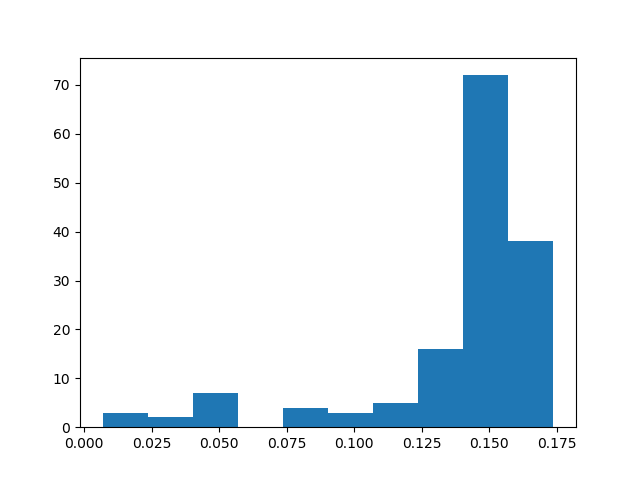

(array([ 3.,  2.,  7.,  0.,  4.,  3.,  5., 16., 72., 38.]),
 array([0.00688 , 0.023567, 0.040254, 0.056941, 0.073628, 0.090315,
        0.107002, 0.123689, 0.140376, 0.157063, 0.17375 ]),
 <a list of 10 Patch objects>)

In [72]:
plt.figure()
plt.hist(sampler.acceptance_fraction)

<IPython.core.display.Javascript object>


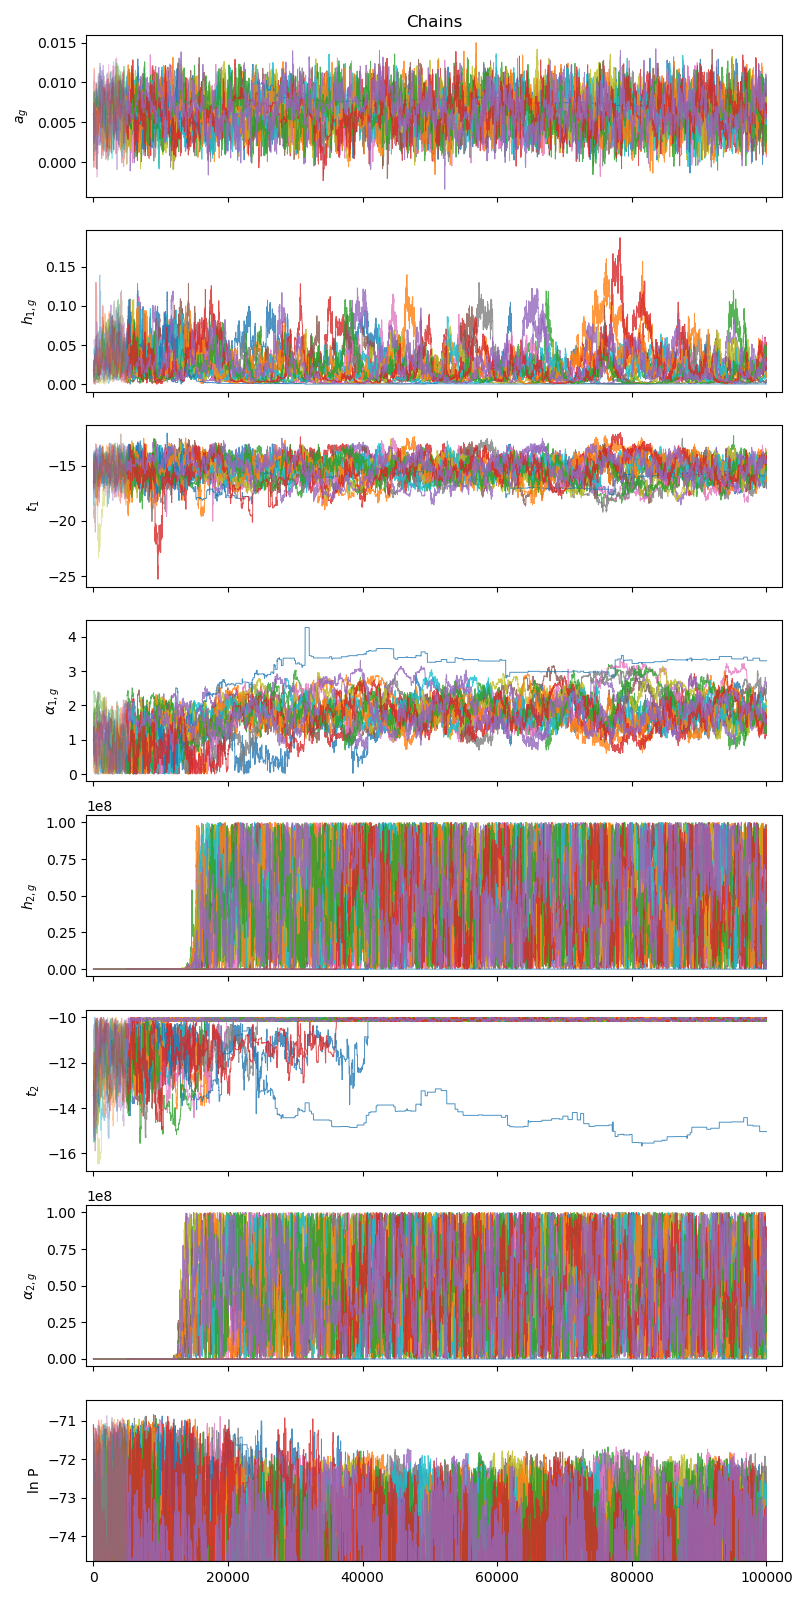

In [73]:
plotChains(sampler, 5000, paramsNames, nplot=15)
plt.tight_layout()

<IPython.core.display.Javascript object>


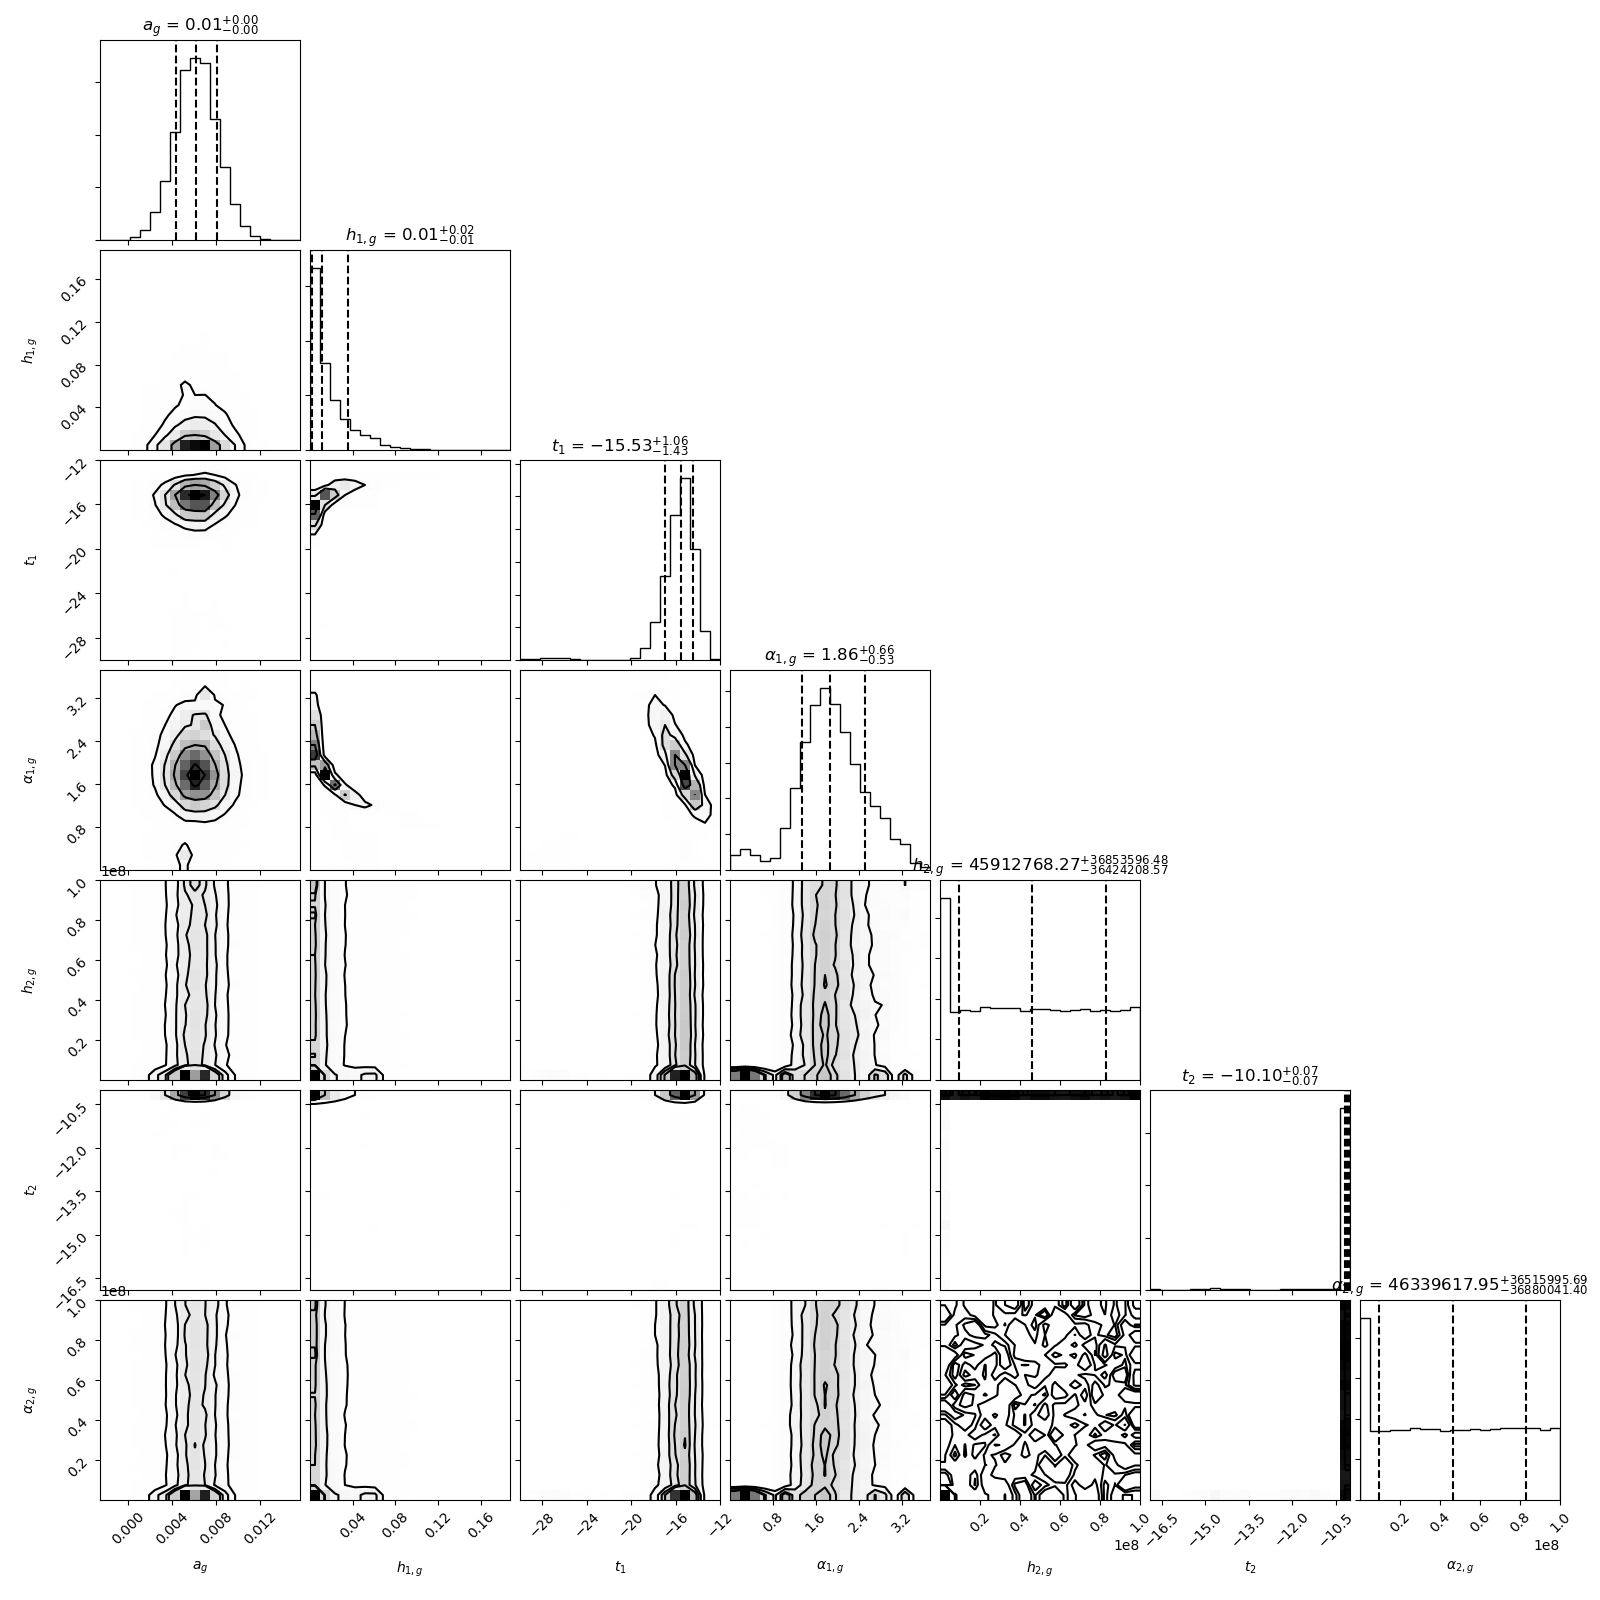

In [75]:
makeCorner(sampler, 75000, paramsNames)

## Fit multiple filters for $t_\mathrm{fl}$ and $\alpha_r$

In [13]:
def multifilter_lnlike_simple(theta, f, t, f_err, filt_arr):
    
    if len(theta) % 3 != 1:
        raise RuntimeError('The correct number of parameters were not included')
    
    ln_l = 0
    for filt_num, filt in enumerate(np.unique(filt_arr)):
        theta_filt = np.append(theta[0], theta[1+3*filt_num:4+3*filt_num])
        filt_obs = np.where(filt_arr == filt)
        f_filt = f[filt_obs]
        t_filt = t[filt_obs]
        f_err_filt = f_err[filt_obs]
        ln_l += lnlike_simple(theta_filt, f_filt, t_filt, f_err_filt)
    
    return ln_l

def multifilter_nll_simple(theta, f, t, f_err, filt_arr):
    return -1*multifilter_lnlike_simple(theta, f, t, f_err, filt_arr)

def multifilter_lnprior_simple(theta, filt_arr):
    
    if len(theta) % 3 != 1:
        raise RuntimeError('The correct number of parameters were not included')
    
    ln_p = 0
    for filt_num, filt in enumerate(np.unique(filt_arr)):
        theta_filt = np.append(theta[0], theta[1+3*filt_num:4+3*filt_num])
        ln_p += lnprior_simple(theta_filt)
    return ln_p

def multifilter_lnposterior_simple(theta, f, t, f_err, filt_arr):
    lnp = multifilter_lnprior_simple(theta, filt_arr)
    lnl = multifilter_lnlike_simple(theta, f, t, f_err, filt_arr)
    if not np.isfinite(lnl):
        return -np.inf
    if not np.isfinite(lnp):
        return -np.inf
    return lnl + lnp

In [14]:
time_rf = (lc_df['jdobs'].iloc[obs].values - t0)/(1+z)
flux = lc_df['Fratio'].iloc[obs].values
g_max = np.max(lc_df['Fratio'].iloc[g_obs].values)
r_max = np.max(lc_df['Fratio'].iloc[g_obs].values)
flux[g_obs] = flux[g_obs]/g_max
flux[r_obs] = flux[r_obs]/r_max
flux_unc = lc_df['Fratio_unc'].iloc[obs].values
flux_unc[g_obs] = flux_unc[g_obs]/g_max
flux_unc[r_obs] = flux_unc[r_obs]/r_max
filt_arr = lc_df['filter'].iloc[obs].values

t_fl = 18

guess_0 = [-t_fl, 
           0, 6e-3, 2,
           0, 6e-3, 2
          ]

half_max_g = np.where((flux[g_obs] < 0.5) & (time_rf[g_obs] < 0))
early_obs = np.where(time_rf <= time_rf[g_obs][np.max(half_max_g[0])])

f_data = flux[early_obs]
t_data = time_rf[early_obs]
f_unc_data = flux_unc[early_obs]
filt_data = filt_arr[early_obs]

print(multifilter_nll_simple(guess_0, flux, time_rf, flux_unc, filt_arr))

116934425132.16048


In [15]:
# initialize near maximum-likelihood result
ml_res = minimize(multifilter_nll_simple, guess_0, method='Powell', # Powell method does not need derivatives
                  args=(f_data, t_data, f_unc_data, filt_data))
ml_guess = ml_res.x
print(ml_guess)
print(multifilter_nll_simple(ml_guess, f_data, t_data, f_unc_data, filt_data))

[-1.69018885e+01 -4.14142600e-04  5.15333281e-03  2.08013990e+00
  2.51131335e-03  7.50862460e-03  1.91338842e+00]
173.76397157115792


In [36]:
###################################
###  sample without sig_0 term  ###
###################################


nwalkers = 100
ndim = len(ml_guess)
nfac = [1e-3]*ndim

#initial position of walkers
pos = [ml_guess + ml_guess * nfac * np.random.randn(ndim) for i in range(nwalkers)]

filename = 'tmp.h5'
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)        


with Pool(4) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, multifilter_lnposterior_simple, 
                                    args=(f_data, t_data, f_unc_data, filt_data),
                                    pool=pool, backend=backend)
    max_samples = 3000
    index = 0
    autocorr = np.empty(max_samples)
    old_tau = np.inf
    check_tau = 25
    for sample in sampler.sample(pos, iterations=max_samples, thin_by=1, progress=True):
        if sampler.iteration % check_tau:
            continue
        
        tstart = time.time()
        tau = sampler.get_autocorr_time(tol=0)
        tend = time.time()
        autocorr[index] = np.mean(tau)
        index += 1
        steps_so_far = index*check_tau
        print('''After {:d} steps, 
autocorrelation takes {:.3f} s ({} total FFTs)                
acceptance fraction = {:.4f}, and
tau = {}'''.format(steps_so_far, 
                   tend-tstart, nwalkers*ndim,
                   np.mean(sampler.acceptance_fraction), 
                   tau))

        # Check convergence
        converged = np.all(tau * 100 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau

  1%|          | 35/3000 [00:00<00:56, 52.31it/s]

After 25 steps, 
autocorrelation takes 0.031 s (700 total FFTs)                
acceptance fraction = 0.5372, and
tau = [2.58130545 2.56244747 2.49635138 2.25190686 2.64488499 2.52411027
 2.51172346]


  2%|▏         | 58/3000 [00:01<00:55, 52.64it/s]

After 50 steps, 
autocorrelation takes 0.025 s (700 total FFTs)                
acceptance fraction = 0.5212, and
tau = [4.83147452 5.09924873 5.11076795 4.97217404 5.13730993 5.17114716
 4.77866838]


  3%|▎         | 83/3000 [00:01<00:53, 54.35it/s]

After 75 steps, 
autocorrelation takes 0.030 s (700 total FFTs)                
acceptance fraction = 0.5067, and
tau = [7.36644648 7.89504376 7.77343322 7.60744399 7.5455232  7.79850109
 7.82475371]


  4%|▎         | 110/3000 [00:02<00:51, 55.82it/s]

After 100 steps, 
autocorrelation takes 0.033 s (700 total FFTs)                
acceptance fraction = 0.4946, and
tau = [ 9.97836603 10.60767929 10.52951457 10.23103535 10.72347077 10.27741238
 10.16635153]


  4%|▍         | 134/3000 [00:02<00:52, 54.52it/s]

After 125 steps, 
autocorrelation takes 0.028 s (700 total FFTs)                
acceptance fraction = 0.4814, and
tau = [12.29843456 13.26364648 12.78784949 12.69359887 13.0625266  12.30056414
 12.30743974]


  5%|▌         | 160/3000 [00:02<00:51, 55.33it/s]

After 150 steps, 
autocorrelation takes 0.032 s (700 total FFTs)                
acceptance fraction = 0.4710, and
tau = [14.54475251 15.99897844 14.59418714 14.62367795 15.33734198 14.47182662
 14.04518733]


  6%|▌         | 185/3000 [00:03<00:52, 53.99it/s]

After 175 steps, 
autocorrelation takes 0.036 s (700 total FFTs)                
acceptance fraction = 0.4606, and
tau = [16.36398382 17.86494933 16.7426478  16.84096947 16.92456397 16.5009012
 15.84160064]


  7%|▋         | 211/3000 [00:03<00:50, 54.71it/s]

After 200 steps, 
autocorrelation takes 0.033 s (700 total FFTs)                
acceptance fraction = 0.4512, and
tau = [18.91920945 19.53259742 19.38961906 19.18954704 18.51868099 19.76812446
 18.67179423]


  8%|▊         | 235/3000 [00:04<00:51, 53.84it/s]

After 225 steps, 
autocorrelation takes 0.034 s (700 total FFTs)                
acceptance fraction = 0.4464, and
tau = [21.18169614 21.10137725 21.49916836 21.16248543 20.31125326 21.74722465
 20.91416822]


  9%|▊         | 260/3000 [00:04<00:49, 54.91it/s]

After 250 steps, 
autocorrelation takes 0.032 s (700 total FFTs)                
acceptance fraction = 0.4385, and
tau = [23.59650934 22.46539166 23.55305884 23.64421524 21.33428652 24.03353476
 23.38889502]


 10%|▉         | 285/3000 [00:05<00:49, 55.33it/s]

After 275 steps, 
autocorrelation takes 0.037 s (700 total FFTs)                
acceptance fraction = 0.4350, and
tau = [25.84060385 24.2795872  25.50349772 25.47018123 22.59530117 26.16500339
 25.18325696]


 10%|█         | 310/3000 [00:05<00:48, 55.01it/s]

After 300 steps, 
autocorrelation takes 0.037 s (700 total FFTs)                
acceptance fraction = 0.4309, and
tau = [28.40241395 26.19061019 27.9504689  27.92446689 23.40925039 27.81496184
 27.07480135]


 11%|█         | 335/3000 [00:06<00:48, 55.17it/s]

After 325 steps, 
autocorrelation takes 0.038 s (700 total FFTs)                
acceptance fraction = 0.4267, and
tau = [30.87665652 27.49413544 30.72970654 30.63843038 25.1540647  29.63885407
 28.86132887]


 12%|█▏        | 360/3000 [00:06<00:47, 55.00it/s]

After 350 steps, 
autocorrelation takes 0.039 s (700 total FFTs)                
acceptance fraction = 0.4223, and
tau = [33.04000808 28.35466413 32.75503597 32.80423512 26.91650772 31.66010926
 30.53007266]


 13%|█▎        | 385/3000 [00:07<00:48, 54.39it/s]

After 375 steps, 
autocorrelation takes 0.038 s (700 total FFTs)                
acceptance fraction = 0.4194, and
tau = [35.07771366 29.31559046 35.12877816 35.34108675 28.21198545 33.88297508
 32.88620091]


 14%|█▎        | 410/3000 [00:07<00:48, 53.65it/s]

After 400 steps, 
autocorrelation takes 0.038 s (700 total FFTs)                
acceptance fraction = 0.4158, and
tau = [37.48404206 30.34269341 37.51240148 37.73957948 29.78958595 36.31109346
 35.37830243]


 14%|█▍        | 435/3000 [00:07<00:47, 53.81it/s]

After 425 steps, 
autocorrelation takes 0.040 s (700 total FFTs)                
acceptance fraction = 0.4131, and
tau = [39.88814546 31.00837237 39.97444445 39.96629168 31.57743991 38.7339165
 37.34314111]


 15%|█▌        | 460/3000 [00:08<00:46, 54.15it/s]

After 450 steps, 
autocorrelation takes 0.040 s (700 total FFTs)                
acceptance fraction = 0.4108, and
tau = [41.82497633 32.29474679 42.46825291 42.30347133 33.01914042 40.50859618
 39.07064834]


 16%|█▌        | 485/3000 [00:08<00:46, 54.11it/s]

After 475 steps, 
autocorrelation takes 0.040 s (700 total FFTs)                
acceptance fraction = 0.4072, and
tau = [43.95341207 33.57443471 44.61409577 44.40922356 34.74566345 42.55125485
 40.77358428]


 17%|█▋        | 510/3000 [00:09<00:46, 53.54it/s]

After 500 steps, 
autocorrelation takes 0.040 s (700 total FFTs)                
acceptance fraction = 0.4047, and
tau = [46.32774336 34.48691026 46.83218848 46.55174982 36.56438686 44.98821013
 42.99309368]


 18%|█▊        | 535/3000 [00:09<00:48, 51.24it/s]

After 525 steps, 
autocorrelation takes 0.074 s (700 total FFTs)                
acceptance fraction = 0.4016, and
tau = [48.35576406 35.7655909  48.71218118 48.71201963 38.2581176  47.09507784
 45.13430735]


 19%|█▊        | 560/3000 [00:10<00:47, 51.89it/s]

After 550 steps, 
autocorrelation takes 0.052 s (700 total FFTs)                
acceptance fraction = 0.3995, and
tau = [50.1367596  37.28728711 50.66592555 50.18264316 39.60004889 49.1131899
 47.09536658]


 20%|█▉        | 585/3000 [00:10<00:46, 52.35it/s]

After 575 steps, 
autocorrelation takes 0.051 s (700 total FFTs)                
acceptance fraction = 0.3980, and
tau = [51.5919792  38.53572533 51.89165582 51.5362992  41.07773769 50.9289259
 49.09605727]


 20%|██        | 610/3000 [00:11<00:46, 51.73it/s]

After 600 steps, 
autocorrelation takes 0.059 s (700 total FFTs)                
acceptance fraction = 0.3961, and
tau = [53.56944531 40.12266751 53.66822278 53.42766537 42.28000448 52.97293127
 51.11408646]


 21%|██        | 635/3000 [00:11<00:44, 52.67it/s]

After 625 steps, 
autocorrelation takes 0.052 s (700 total FFTs)                
acceptance fraction = 0.3952, and
tau = [55.10070998 41.49508821 55.66326546 55.14118098 42.71038954 54.61810312
 52.85434756]


 22%|██▏       | 659/3000 [00:12<00:45, 51.46it/s]

After 650 steps, 
autocorrelation takes 0.054 s (700 total FFTs)                
acceptance fraction = 0.3934, and
tau = [56.9386418  42.43416498 57.2652222  56.32944923 43.48087049 56.2434021
 54.51695665]


 23%|██▎       | 684/3000 [00:12<00:44, 51.51it/s]

After 675 steps, 
autocorrelation takes 0.055 s (700 total FFTs)                
acceptance fraction = 0.3917, and
tau = [58.56654846 43.61622532 58.48753206 57.76098749 44.36263944 58.00048818
 56.31025309]


 24%|██▎       | 709/3000 [00:13<00:44, 51.46it/s]

After 700 steps, 
autocorrelation takes 0.055 s (700 total FFTs)                
acceptance fraction = 0.3902, and
tau = [60.02333612 44.38097143 60.17374714 59.54399425 45.22117787 59.61513777
 57.98192512]


 24%|██▍       | 733/3000 [00:13<00:45, 49.75it/s]

After 725 steps, 
autocorrelation takes 0.061 s (700 total FFTs)                
acceptance fraction = 0.3894, and
tau = [61.92529463 45.57311713 62.2074337  61.4996858  46.40931358 61.72625144
 60.16913594]


 25%|██▌       | 758/3000 [00:14<00:44, 50.50it/s]

After 750 steps, 
autocorrelation takes 0.060 s (700 total FFTs)                
acceptance fraction = 0.3878, and
tau = [64.0081827  46.6907401  64.47114749 63.77292365 47.94915109 63.72999186
 62.19906676]


 26%|██▌       | 783/3000 [00:14<00:43, 50.97it/s]

After 775 steps, 
autocorrelation takes 0.059 s (700 total FFTs)                
acceptance fraction = 0.3863, and
tau = [66.43582164 47.40823981 67.1442854  66.37234943 49.50080314 65.98808462
 64.55755717]


 27%|██▋       | 807/3000 [00:15<00:43, 50.27it/s]

After 800 steps, 
autocorrelation takes 0.061 s (700 total FFTs)                
acceptance fraction = 0.3847, and
tau = [68.93272156 48.56250494 69.37432199 68.79956898 51.05702016 68.20103738
 66.74013154]


 28%|██▊       | 837/3000 [00:15<00:42, 50.72it/s]

After 825 steps, 
autocorrelation takes 0.064 s (700 total FFTs)                
acceptance fraction = 0.3838, and
tau = [71.42980961 49.26577067 72.06109882 71.10425649 52.54265811 70.21822675
 68.78053792]


 29%|██▊       | 862/3000 [00:16<00:42, 50.50it/s]

After 850 steps, 
autocorrelation takes 0.062 s (700 total FFTs)                
acceptance fraction = 0.3828, and
tau = [73.83073313 49.59828205 74.51429265 73.71438596 53.80784019 72.36620686
 70.7676346 ]


 30%|██▉       | 886/3000 [00:16<00:41, 50.59it/s]

After 875 steps, 
autocorrelation takes 0.063 s (700 total FFTs)                
acceptance fraction = 0.3815, and
tau = [76.29719421 50.05484897 77.08836392 76.35824367 55.15452622 74.46607107
 72.75199995]


 30%|███       | 911/3000 [00:17<00:41, 50.17it/s]

After 900 steps, 
autocorrelation takes 0.071 s (700 total FFTs)                
acceptance fraction = 0.3806, and
tau = [78.93157817 50.16876121 79.97785499 79.04128    56.59419296 76.8373763
 74.92887449]


 31%|███▏      | 938/3000 [00:17<00:39, 51.90it/s]

After 925 steps, 
autocorrelation takes 0.064 s (700 total FFTs)                
acceptance fraction = 0.3790, and
tau = [80.96148343 50.1523853  82.32969912 81.48107376 57.91608237 78.87432059
 76.8904312 ]


 32%|███▏      | 958/3000 [00:17<00:39, 51.10it/s]

After 950 steps, 
autocorrelation takes 0.062 s (700 total FFTs)                
acceptance fraction = 0.3779, and
tau = [83.45119785 50.26179693 84.63311111 83.97479749 59.18252961 80.95224691
 79.03600227]


 33%|███▎      | 984/3000 [00:18<00:39, 51.09it/s]

After 975 steps, 
autocorrelation takes 0.064 s (700 total FFTs)                
acceptance fraction = 0.3770, and
tau = [86.04522298 49.85234448 87.60614232 86.94982764 60.0833448  83.78324316
 81.51762044]


 34%|███▎      | 1011/3000 [00:18<00:38, 51.42it/s]

After 1000 steps, 
autocorrelation takes 0.062 s (700 total FFTs)                
acceptance fraction = 0.3761, and
tau = [88.4863269  50.19004315 90.21061431 89.78845025 61.10899347 85.83308434
 83.7876619 ]


 35%|███▍      | 1037/3000 [00:19<00:39, 49.38it/s]

After 1025 steps, 
autocorrelation takes 0.085 s (700 total FFTs)                
acceptance fraction = 0.3750, and
tau = [90.39840308 50.76752863 92.1202042  91.91897983 62.58665223 87.61963778
 85.43006076]


 35%|███▌      | 1056/3000 [00:19<00:43, 45.09it/s]

After 1050 steps, 
autocorrelation takes 0.088 s (700 total FFTs)                
acceptance fraction = 0.3743, and
tau = [92.14340022 51.62883581 94.29798676 93.77042423 63.46718812 89.2105831
 87.04570675]


 36%|███▌      | 1083/3000 [00:20<00:40, 47.76it/s]

After 1075 steps, 
autocorrelation takes 0.089 s (700 total FFTs)                
acceptance fraction = 0.3733, and
tau = [94.16823861 52.88343506 96.21653682 95.78539295 64.39747431 91.0106507
 89.05166154]


 37%|███▋      | 1108/3000 [00:20<00:39, 47.94it/s]

After 1100 steps, 
autocorrelation takes 0.080 s (700 total FFTs)                
acceptance fraction = 0.3723, and
tau = [96.09653917 54.23713515 98.20529291 97.89703418 65.50897297 93.19170844
 91.13759907]


 38%|███▊      | 1133/3000 [00:21<00:39, 47.63it/s]

After 1125 steps, 
autocorrelation takes 0.088 s (700 total FFTs)                
acceptance fraction = 0.3718, and
tau = [97.82726144 55.3848973  99.95330771 99.71977628 66.13624363 94.96359798
 92.75015387]


 39%|███▊      | 1157/3000 [00:21<00:38, 48.14it/s]

After 1150 steps, 
autocorrelation takes 0.082 s (700 total FFTs)                
acceptance fraction = 0.3712, and
tau = [ 99.47335451  56.68999415 101.42735789 101.20832276  66.67851519
  96.36431053  94.3104301 ]


 39%|███▉      | 1183/3000 [00:22<00:36, 49.17it/s]

After 1175 steps, 
autocorrelation takes 0.087 s (700 total FFTs)                
acceptance fraction = 0.3707, and
tau = [100.93004934  57.9842356  102.34176489 102.32187622  67.4347413
  97.88718631  95.41273073]


 40%|████      | 1208/3000 [00:22<00:37, 48.27it/s]

After 1200 steps, 
autocorrelation takes 0.087 s (700 total FFTs)                
acceptance fraction = 0.3697, and
tau = [102.1091862   59.22119569 103.81538224 103.40286123  68.32049116
  99.35999956  97.15632251]


 41%|████      | 1233/3000 [00:23<00:37, 47.38it/s]

After 1225 steps, 
autocorrelation takes 0.092 s (700 total FFTs)                
acceptance fraction = 0.3686, and
tau = [104.01760568  60.73899973 105.39698741 104.90820863  69.18719395
 101.33940657  99.14174625]


 42%|████▏     | 1258/3000 [00:24<00:37, 46.20it/s]

After 1250 steps, 
autocorrelation takes 0.092 s (700 total FFTs)                
acceptance fraction = 0.3677, and
tau = [105.99259592  61.8634637  107.11567948 107.0004639   69.9618338
 103.53810882 101.24495655]


 43%|████▎     | 1282/3000 [00:24<00:36, 46.65it/s]

After 1275 steps, 
autocorrelation takes 0.087 s (700 total FFTs)                
acceptance fraction = 0.3664, and
tau = [107.74503924  63.09390543 109.13884588 108.59597471  70.61264267
 105.62153581 103.38050466]


 44%|████▎     | 1312/3000 [00:25<00:35, 48.12it/s]

After 1300 steps, 
autocorrelation takes 0.089 s (700 total FFTs)                
acceptance fraction = 0.3653, and
tau = [109.60593258  64.17051155 110.68636671 110.18267205  71.37691995
 107.96771752 105.72313545]


 45%|████▍     | 1337/3000 [00:25<00:34, 47.98it/s]

After 1325 steps, 
autocorrelation takes 0.087 s (700 total FFTs)                
acceptance fraction = 0.3644, and
tau = [111.708907    64.92955145 112.75432608 112.33844907  72.71996956
 110.08636198 107.95810923]


 45%|████▌     | 1362/3000 [00:26<00:34, 48.12it/s]

After 1350 steps, 
autocorrelation takes 0.089 s (700 total FFTs)                
acceptance fraction = 0.3631, and
tau = [113.50251138  65.71307224 114.4357377  114.08272977  74.14975594
 112.33146106 110.3275816 ]


 46%|████▌     | 1387/3000 [00:26<00:33, 47.61it/s]

After 1375 steps, 
autocorrelation takes 0.091 s (700 total FFTs)                
acceptance fraction = 0.3619, and
tau = [115.70904707  66.50744443 116.66492105 116.36538335  75.59860658
 114.67947793 112.38536214]


 47%|████▋     | 1406/3000 [00:27<00:36, 43.48it/s]

After 1400 steps, 
autocorrelation takes 0.093 s (700 total FFTs)                
acceptance fraction = 0.3611, and
tau = [118.18917479  67.44038239 119.11961767 118.70449438  76.95719032
 117.0466733  114.93389811]


 48%|████▊     | 1437/3000 [00:27<00:32, 47.37it/s]

After 1425 steps, 
autocorrelation takes 0.092 s (700 total FFTs)                
acceptance fraction = 0.3601, and
tau = [120.8087905   68.36336603 121.72327674 121.38764918  78.47700363
 119.8259948  117.69359043]


 49%|████▊     | 1462/3000 [00:28<00:32, 47.36it/s]

After 1450 steps, 
autocorrelation takes 0.093 s (700 total FFTs)                
acceptance fraction = 0.3590, and
tau = [123.87565288  68.67349076 124.4706211  124.3970185   79.90021824
 122.57873057 120.44509333]


 50%|████▉     | 1487/3000 [00:28<00:31, 47.31it/s]

After 1475 steps, 
autocorrelation takes 0.098 s (700 total FFTs)                
acceptance fraction = 0.3579, and
tau = [126.52102092  69.18667677 127.11396449 127.09254791  80.75366103
 125.18559304 123.13447764]


 50%|█████     | 1512/3000 [00:29<00:31, 47.55it/s]

After 1500 steps, 
autocorrelation takes 0.092 s (700 total FFTs)                
acceptance fraction = 0.3570, and
tau = [129.55203674  70.09973535 129.99708757 129.77419487  81.92874297
 127.91179798 125.54070953]


 51%|█████     | 1537/3000 [00:29<00:30, 47.66it/s]

After 1525 steps, 
autocorrelation takes 0.092 s (700 total FFTs)                
acceptance fraction = 0.3562, and
tau = [131.89981035  71.38258871 132.55637741 132.52788848  82.48438409
 130.3382231  128.04155769]


 52%|█████▏    | 1556/3000 [00:30<00:32, 43.77it/s]

After 1550 steps, 
autocorrelation takes 0.094 s (700 total FFTs)                
acceptance fraction = 0.3551, and
tau = [134.20717733  72.80851647 135.08244612 135.05721867  83.23198896
 132.61736558 130.42646269]


 53%|█████▎    | 1582/3000 [00:30<00:30, 47.04it/s]

After 1575 steps, 
autocorrelation takes 0.093 s (700 total FFTs)                
acceptance fraction = 0.3544, and
tau = [136.53930581  74.30233468 137.64465847 137.58682278  83.96581604
 134.92287565 132.52756959]


 54%|█████▎    | 1606/3000 [00:31<00:32, 42.95it/s]

After 1600 steps, 
autocorrelation takes 0.097 s (700 total FFTs)                
acceptance fraction = 0.3537, and
tau = [138.75018227  75.37998471 139.77885025 139.68698172  84.7944926
 136.69125011 134.51806072]


 55%|█████▍    | 1637/3000 [00:31<00:29, 46.29it/s]

After 1625 steps, 
autocorrelation takes 0.102 s (700 total FFTs)                
acceptance fraction = 0.3530, and
tau = [140.92159744  76.52994692 141.92646945 141.79190712  85.59537392
 139.08538335 136.72377049]


 55%|█████▌    | 1661/3000 [00:32<00:28, 46.55it/s]

After 1650 steps, 
autocorrelation takes 0.098 s (700 total FFTs)                
acceptance fraction = 0.3525, and
tau = [143.35522047  77.70728356 144.17442774 144.14341374  85.97425295
 141.45877603 139.03505511]


 56%|█████▌    | 1686/3000 [00:32<00:27, 47.19it/s]

After 1675 steps, 
autocorrelation takes 0.096 s (700 total FFTs)                
acceptance fraction = 0.3519, and
tau = [145.71089574  78.52268981 146.75694518 146.47308569  86.12815624
 143.71376361 141.35152914]


 57%|█████▋    | 1711/3000 [00:33<00:27, 46.68it/s]

After 1700 steps, 
autocorrelation takes 0.098 s (700 total FFTs)                
acceptance fraction = 0.3511, and
tau = [148.00732298  79.45587435 148.79765904 148.79763417  86.17930409
 145.93980131 143.33435641]


 58%|█████▊    | 1735/3000 [00:33<00:27, 45.64it/s]

After 1725 steps, 
autocorrelation takes 0.103 s (700 total FFTs)                
acceptance fraction = 0.3503, and
tau = [150.16259413  80.59757314 151.27975873 151.02353555  86.09894124
 148.39451454 145.52935709]


 59%|█████▊    | 1760/3000 [00:34<00:27, 45.40it/s]

After 1750 steps, 
autocorrelation takes 0.103 s (700 total FFTs)                
acceptance fraction = 0.3493, and
tau = [152.74484722  81.81529868 153.87174209 153.61226511  85.94294952
 150.67002814 147.91985242]


 60%|█████▉    | 1785/3000 [00:35<00:26, 46.41it/s]

After 1775 steps, 
autocorrelation takes 0.096 s (700 total FFTs)                
acceptance fraction = 0.3484, and
tau = [155.32363077  83.12960007 156.46879771 156.3673692   86.00558908
 153.47249254 150.72506588]


 60%|██████    | 1810/3000 [00:35<00:25, 46.10it/s]

After 1800 steps, 
autocorrelation takes 0.106 s (700 total FFTs)                
acceptance fraction = 0.3477, and
tau = [158.16542792  84.42755002 159.3972046  158.93913663  86.10614842
 156.05657262 153.46276728]


 61%|██████    | 1834/3000 [00:36<00:25, 45.17it/s]

After 1825 steps, 
autocorrelation takes 0.102 s (700 total FFTs)                
acceptance fraction = 0.3469, and
tau = [160.64106194  85.82327291 161.99639998 161.48514194  86.35445017
 158.49639663 155.50054917]


 62%|██████▏   | 1858/3000 [00:36<00:25, 45.35it/s]

After 1850 steps, 
autocorrelation takes 0.101 s (700 total FFTs)                
acceptance fraction = 0.3462, and
tau = [162.91605847  86.99398936 164.02493007 163.6479153   86.20164323
 160.71620988 157.65985011]


 63%|██████▎   | 1883/3000 [00:37<00:24, 45.87it/s]

After 1875 steps, 
autocorrelation takes 0.102 s (700 total FFTs)                
acceptance fraction = 0.3454, and
tau = [165.23876901  87.80275306 166.40619702 165.96318202  86.28779925
 162.84103621 159.58285961]


 64%|██████▎   | 1908/3000 [00:37<00:23, 46.40it/s]

After 1900 steps, 
autocorrelation takes 0.102 s (700 total FFTs)                
acceptance fraction = 0.3448, and
tau = [167.5811715   88.36701664 168.65929227 168.33905814  86.79286897
 164.74963087 161.38934346]


 64%|██████▍   | 1933/3000 [00:38<00:23, 46.26it/s]

After 1925 steps, 
autocorrelation takes 0.104 s (700 total FFTs)                
acceptance fraction = 0.3441, and
tau = [169.8988653   88.68730217 170.95755586 170.67599873  87.26462852
 167.0386476  163.61053421]


 65%|██████▌   | 1958/3000 [00:38<00:22, 46.13it/s]

After 1950 steps, 
autocorrelation takes 0.105 s (700 total FFTs)                
acceptance fraction = 0.3433, and
tau = [172.3682017   89.19982749 173.79499571 173.25976551  87.88586499
 169.60414986 165.84749848]


 66%|██████▌   | 1983/3000 [00:39<00:21, 46.30it/s]

After 1975 steps, 
autocorrelation takes 0.104 s (700 total FFTs)                
acceptance fraction = 0.3424, and
tau = [175.08607007  89.50608125 176.05146941 175.60251004  88.55855431
 172.1317067  168.380467  ]


 67%|██████▋   | 2008/3000 [00:39<00:21, 46.33it/s]

After 2000 steps, 
autocorrelation takes 0.102 s (700 total FFTs)                
acceptance fraction = 0.3418, and
tau = [177.49829142  89.77866824 178.52618044 177.84631311  89.32719908
 174.53542058 170.40466761]


 68%|██████▊   | 2033/3000 [00:40<00:20, 46.39it/s]

After 2025 steps, 
autocorrelation takes 0.102 s (700 total FFTs)                
acceptance fraction = 0.3412, and
tau = [180.07605443  89.99345638 180.98370353 180.17781924  90.19949706
 176.59650495 172.6082482 ]


 69%|██████▊   | 2056/3000 [00:40<00:22, 41.10it/s]

After 2050 steps, 
autocorrelation takes 0.145 s (700 total FFTs)                
acceptance fraction = 0.3408, and
tau = [182.27681332  90.39122102 183.09333348 182.48358459  91.16031333
 178.85966183 174.45113312]


 69%|██████▉   | 2084/3000 [00:41<00:23, 39.47it/s]

After 2075 steps, 
autocorrelation takes 0.141 s (700 total FFTs)                
acceptance fraction = 0.3403, and
tau = [184.63174199  90.93082496 185.35048211 184.78760927  92.34807817
 181.18328797 176.61792808]


 70%|███████   | 2107/3000 [00:42<00:24, 37.01it/s]

After 2100 steps, 
autocorrelation takes 0.155 s (700 total FFTs)                
acceptance fraction = 0.3400, and
tau = [186.765398    91.33179917 187.8288284  187.37358367  93.33746432
 183.35185634 178.95333306]


 71%|███████   | 2133/3000 [00:42<00:23, 36.21it/s]

After 2125 steps, 
autocorrelation takes 0.147 s (700 total FFTs)                
acceptance fraction = 0.3394, and
tau = [188.9729312   91.52498392 190.13243808 189.49176833  94.49552748
 185.6554751  181.17286403]


 72%|███████▏  | 2156/3000 [00:43<00:22, 37.73it/s]

After 2150 steps, 
autocorrelation takes 0.151 s (700 total FFTs)                
acceptance fraction = 0.3386, and
tau = [191.30094689  91.93034173 192.20909821 191.68535502  95.28086826
 187.79447723 183.17942077]


 73%|███████▎  | 2181/3000 [00:44<00:24, 33.54it/s]

After 2175 steps, 
autocorrelation takes 0.165 s (700 total FFTs)                
acceptance fraction = 0.3383, and
tau = [193.3787717   92.59081198 194.12800809 193.74166903  95.85496746
 189.54095802 185.41859069]


 74%|███████▎  | 2205/3000 [00:44<00:27, 28.52it/s]

After 2200 steps, 
autocorrelation takes 0.176 s (700 total FFTs)                
acceptance fraction = 0.3377, and
tau = [195.51840683  93.08761782 196.28136001 195.92296998  96.39404115
 192.04989541 187.89911454]


 74%|███████▍  | 2230/3000 [00:45<00:27, 27.99it/s]

After 2225 steps, 
autocorrelation takes 0.182 s (700 total FFTs)                
acceptance fraction = 0.3371, and
tau = [197.79671276  93.667719   198.68607474 198.15621888  96.73222599
 194.22401379 190.23763738]


 75%|███████▌  | 2257/3000 [00:46<00:22, 32.43it/s]

After 2250 steps, 
autocorrelation takes 0.163 s (700 total FFTs)                
acceptance fraction = 0.3365, and
tau = [200.01394263  94.34320387 200.9991195  200.5729483   97.31054114
 196.71127506 192.52581018]


 76%|███████▌  | 2284/3000 [00:46<00:20, 35.41it/s]

After 2275 steps, 
autocorrelation takes 0.151 s (700 total FFTs)                
acceptance fraction = 0.3360, and
tau = [202.06398895  95.04064298 203.10575452 202.65902918  98.2019093
 198.53265762 194.42086147]


 77%|███████▋  | 2307/3000 [00:47<00:18, 36.55it/s]

After 2300 steps, 
autocorrelation takes 0.151 s (700 total FFTs)                
acceptance fraction = 0.3357, and
tau = [203.43787523  95.70633769 204.37260202 203.99518653  98.71322262
 199.89796847 195.66587475]


 78%|███████▊  | 2331/3000 [00:48<00:18, 35.30it/s]

After 2325 steps, 
autocorrelation takes 0.157 s (700 total FFTs)                
acceptance fraction = 0.3353, and
tau = [204.46893662  96.53461602 205.33716696 204.79306212  99.26097938
 201.18168756 196.76162921]


 79%|███████▊  | 2360/3000 [00:48<00:16, 38.64it/s]

After 2350 steps, 
autocorrelation takes 0.152 s (700 total FFTs)                
acceptance fraction = 0.3349, and
tau = [205.70237682  97.19993833 206.5645632  206.18436388  99.68372714
 202.34506715 198.23656104]


 79%|███████▉  | 2383/3000 [00:49<00:15, 38.58it/s]

After 2375 steps, 
autocorrelation takes 0.150 s (700 total FFTs)                
acceptance fraction = 0.3343, and
tau = [206.99127183  97.56819749 207.97548696 207.64118937 100.13072445
 203.94026018 199.74748282]


 80%|████████  | 2407/3000 [00:50<00:15, 39.12it/s]

After 2400 steps, 
autocorrelation takes 0.148 s (700 total FFTs)                
acceptance fraction = 0.3339, and
tau = [208.62396369  97.93689439 209.53910165 209.21330881 100.30340558
 205.29825135 201.3470297 ]


 81%|████████  | 2431/3000 [00:50<00:15, 35.72it/s]

After 2425 steps, 
autocorrelation takes 0.156 s (700 total FFTs)                
acceptance fraction = 0.3332, and
tau = [210.210722    98.58629011 211.16325166 210.94398757 100.50313689
 206.8960458  202.71622897]


 82%|████████▏ | 2459/3000 [00:51<00:14, 38.40it/s]

After 2450 steps, 
autocorrelation takes 0.153 s (700 total FFTs)                
acceptance fraction = 0.3328, and
tau = [211.85058625  99.29778205 212.98277162 212.47610634 100.72806955
 208.26598361 204.3199014 ]


 83%|████████▎ | 2483/3000 [00:51<00:13, 38.53it/s]

After 2475 steps, 
autocorrelation takes 0.150 s (700 total FFTs)                
acceptance fraction = 0.3324, and
tau = [213.34093473 100.12151343 214.36409186 213.86287499 100.67916715
 209.59392722 205.42414787]


 84%|████████▎ | 2507/3000 [00:52<00:12, 38.89it/s]

After 2500 steps, 
autocorrelation takes 0.150 s (700 total FFTs)                
acceptance fraction = 0.3320, and
tau = [214.69993189 100.93712366 215.57388589 215.16118389 100.72381346
 210.80116573 206.82403349]


 84%|████████▍ | 2531/3000 [00:53<00:13, 35.66it/s]

After 2525 steps, 
autocorrelation takes 0.156 s (700 total FFTs)                
acceptance fraction = 0.3317, and
tau = [216.19009226 101.39305113 217.31532844 216.88620598 100.78453758
 212.56101862 208.28900701]


 85%|████████▌ | 2560/3000 [00:53<00:11, 37.66it/s]

After 2550 steps, 
autocorrelation takes 0.158 s (700 total FFTs)                
acceptance fraction = 0.3314, and
tau = [217.77797626 102.00367225 218.85000391 218.32645182 101.03581249
 213.96203213 209.83732718]


 86%|████████▌ | 2582/3000 [00:54<00:11, 34.95it/s]

After 2575 steps, 
autocorrelation takes 0.166 s (700 total FFTs)                
acceptance fraction = 0.3310, and
tau = [218.99254899 102.54457856 220.23644652 219.64832332 101.27162367
 215.46831917 211.28119867]


 87%|████████▋ | 2609/3000 [00:55<00:11, 34.64it/s]

After 2600 steps, 
autocorrelation takes 0.169 s (700 total FFTs)                
acceptance fraction = 0.3307, and
tau = [220.4449586  103.34394909 221.73057296 221.38184034 101.68883939
 217.13584164 212.94057485]


 88%|████████▊ | 2632/3000 [00:55<00:10, 35.62it/s]

After 2625 steps, 
autocorrelation takes 0.159 s (700 total FFTs)                
acceptance fraction = 0.3303, and
tau = [221.73424436 104.13371328 223.32681539 222.87102058 102.22853545
 218.46684433 214.23993834]


 89%|████████▊ | 2659/3000 [00:56<00:09, 36.02it/s]

After 2650 steps, 
autocorrelation takes 0.159 s (700 total FFTs)                
acceptance fraction = 0.3298, and
tau = [223.54627742 104.78167177 225.09938231 224.48646339 102.68269084
 220.05003733 215.59811183]


 89%|████████▉ | 2682/3000 [00:56<00:08, 36.36it/s]

After 2675 steps, 
autocorrelation takes 0.157 s (700 total FFTs)                
acceptance fraction = 0.3295, and
tau = [225.15530849 105.38573693 226.93392956 226.2401847  103.20848944
 221.60669411 217.07982464]


 90%|█████████ | 2706/3000 [00:57<00:08, 34.32it/s]

After 2700 steps, 
autocorrelation takes 0.161 s (700 total FFTs)                
acceptance fraction = 0.3292, and
tau = [227.07865665 105.6294748  228.65400542 227.97006465 103.56951828
 223.24635824 218.68671204]


 91%|█████████ | 2730/3000 [00:58<00:07, 34.20it/s]

After 2725 steps, 
autocorrelation takes 0.159 s (700 total FFTs)                
acceptance fraction = 0.3288, and
tau = [228.94641686 105.99313207 230.76741633 229.86555996 103.50997182
 225.07549462 220.38817564]


 92%|█████████▏| 2758/3000 [00:58<00:06, 37.54it/s]

After 2750 steps, 
autocorrelation takes 0.155 s (700 total FFTs)                
acceptance fraction = 0.3283, and
tau = [230.85491324 106.504865   232.58883934 231.65873958 104.09646013
 226.51895239 221.67564692]


 93%|█████████▎| 2782/3000 [00:59<00:05, 38.25it/s]

After 2775 steps, 
autocorrelation takes 0.159 s (700 total FFTs)                
acceptance fraction = 0.3281, and
tau = [232.39531763 106.64911922 234.26300654 233.56578167 104.7978055
 227.94301795 222.97432583]


 94%|█████████▎| 2806/3000 [01:00<00:05, 35.37it/s]

After 2800 steps, 
autocorrelation takes 0.159 s (700 total FFTs)                
acceptance fraction = 0.3278, and
tau = [234.1565317  106.91807357 236.26793932 235.3558721  105.28428789
 229.58862466 224.56760836]


 94%|█████████▍| 2830/3000 [01:00<00:04, 34.61it/s]

After 2825 steps, 
autocorrelation takes 0.158 s (700 total FFTs)                
acceptance fraction = 0.3277, and
tau = [235.88414131 107.28888969 238.37846255 237.59941391 105.98689546
 231.27647263 225.95634909]


 95%|█████████▌| 2857/3000 [01:01<00:04, 35.72it/s]

After 2850 steps, 
autocorrelation takes 0.160 s (700 total FFTs)                
acceptance fraction = 0.3274, and
tau = [237.35347957 107.75495734 240.06954688 239.31046446 106.69606992
 233.04900191 227.58375378]


 96%|█████████▌| 2880/3000 [01:01<00:03, 34.33it/s]

After 2875 steps, 
autocorrelation takes 0.161 s (700 total FFTs)                
acceptance fraction = 0.3273, and
tau = [239.30766939 107.95967721 241.95997949 241.10395532 107.20392965
 234.9052086  229.08316805]


 97%|█████████▋| 2907/3000 [01:02<00:02, 34.44it/s]

After 2900 steps, 
autocorrelation takes 0.166 s (700 total FFTs)                
acceptance fraction = 0.3272, and
tau = [241.18333932 108.54123317 244.1032816  243.0832443  107.64886107
 236.76131635 231.0859988 ]


 98%|█████████▊| 2931/3000 [01:03<00:02, 33.74it/s]

After 2925 steps, 
autocorrelation takes 0.168 s (700 total FFTs)                
acceptance fraction = 0.3269, and
tau = [243.40564784 109.3189224  246.04242443 245.19886144 108.019315
 239.02204881 233.18228586]


 99%|█████████▊| 2959/3000 [01:04<00:01, 36.42it/s]

After 2950 steps, 
autocorrelation takes 0.170 s (700 total FFTs)                
acceptance fraction = 0.3267, and
tau = [245.33021226 110.10794936 248.04859523 247.14654287 108.39195305
 241.04530155 235.25361788]


 99%|█████████▉| 2981/3000 [01:04<00:00, 33.58it/s]

After 2975 steps, 
autocorrelation takes 0.190 s (700 total FFTs)                
acceptance fraction = 0.3262, and
tau = [247.45674049 110.66108436 250.15940728 249.33122351 108.70101846
 243.23111043 237.2029516 ]


100%|██████████| 3000/3000 [01:05<00:00, 46.01it/s]

After 3000 steps, 
autocorrelation takes 0.182 s (700 total FFTs)                
acceptance fraction = 0.3260, and
tau = [249.25772819 111.39343012 252.15567583 251.05700585 109.09455329
 245.34955338 239.35519222]


After 100 steps, 
autocorrelation takes 0.035 s (700 total FFTs)                
acceptance fraction = 0.2732, and
tau = [5.84013413 1.91818081 5.82661309 5.82264879 1.9015862  5.77467252
 5.72451288]

In [27]:
reader = emcee.backends.HDFBackend(filename)
np.shape(reader.get_chain())

(100, 100, 7)

<IPython.core.display.Javascript object>


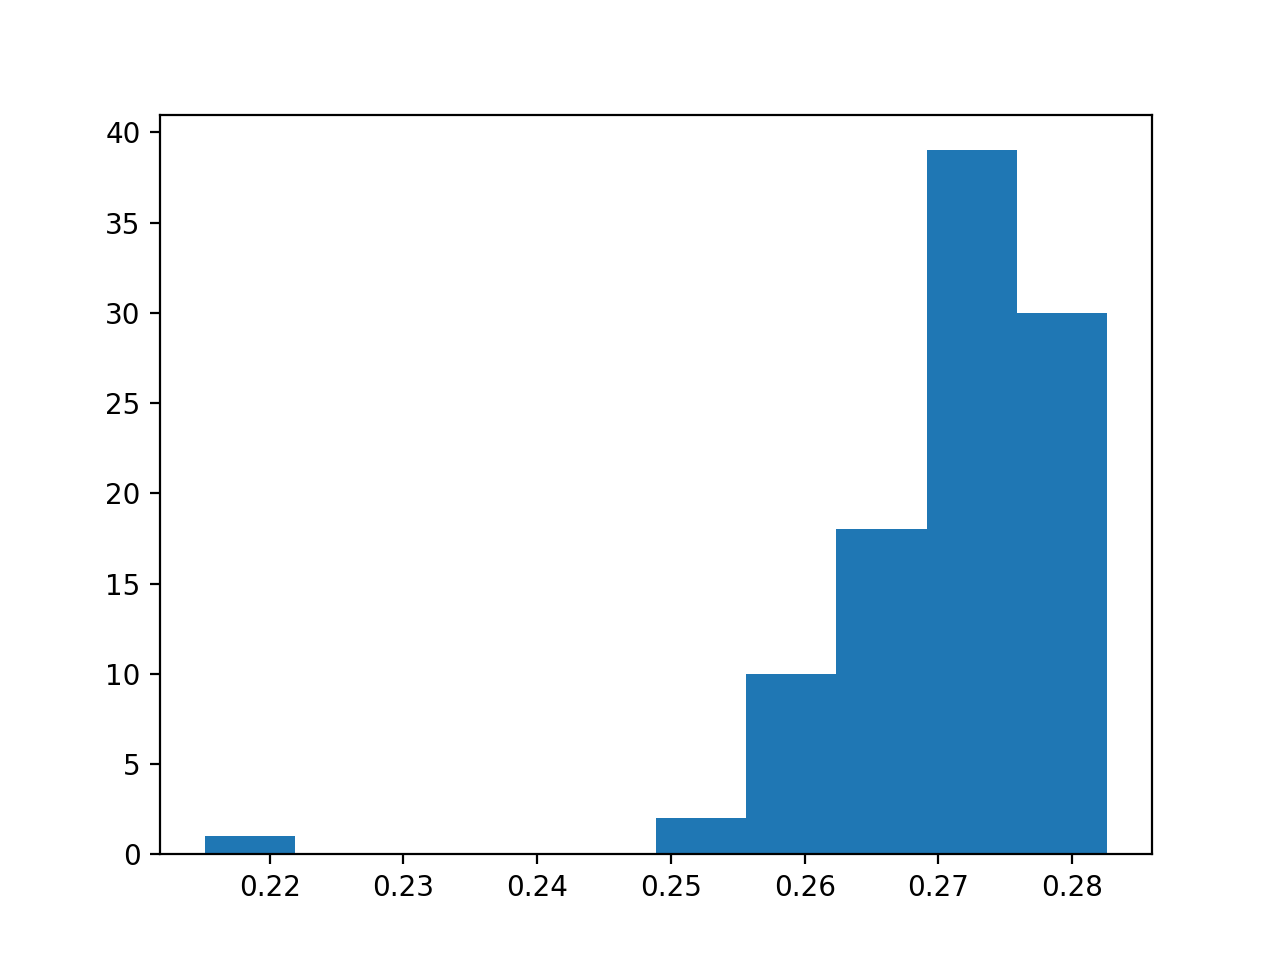

(array([ 1.,  0.,  0.,  0.,  0.,  2., 10., 18., 39., 30.]),
 array([0.21517  , 0.2219125, 0.228655 , 0.2353975, 0.24214  , 0.2488825,
        0.255625 , 0.2623675, 0.26911  , 0.2758525, 0.282595 ]),
 <a list of 10 Patch objects>)

In [14]:
plt.figure()
plt.hist(sampler.acceptance_fraction)

<IPython.core.display.Javascript object>


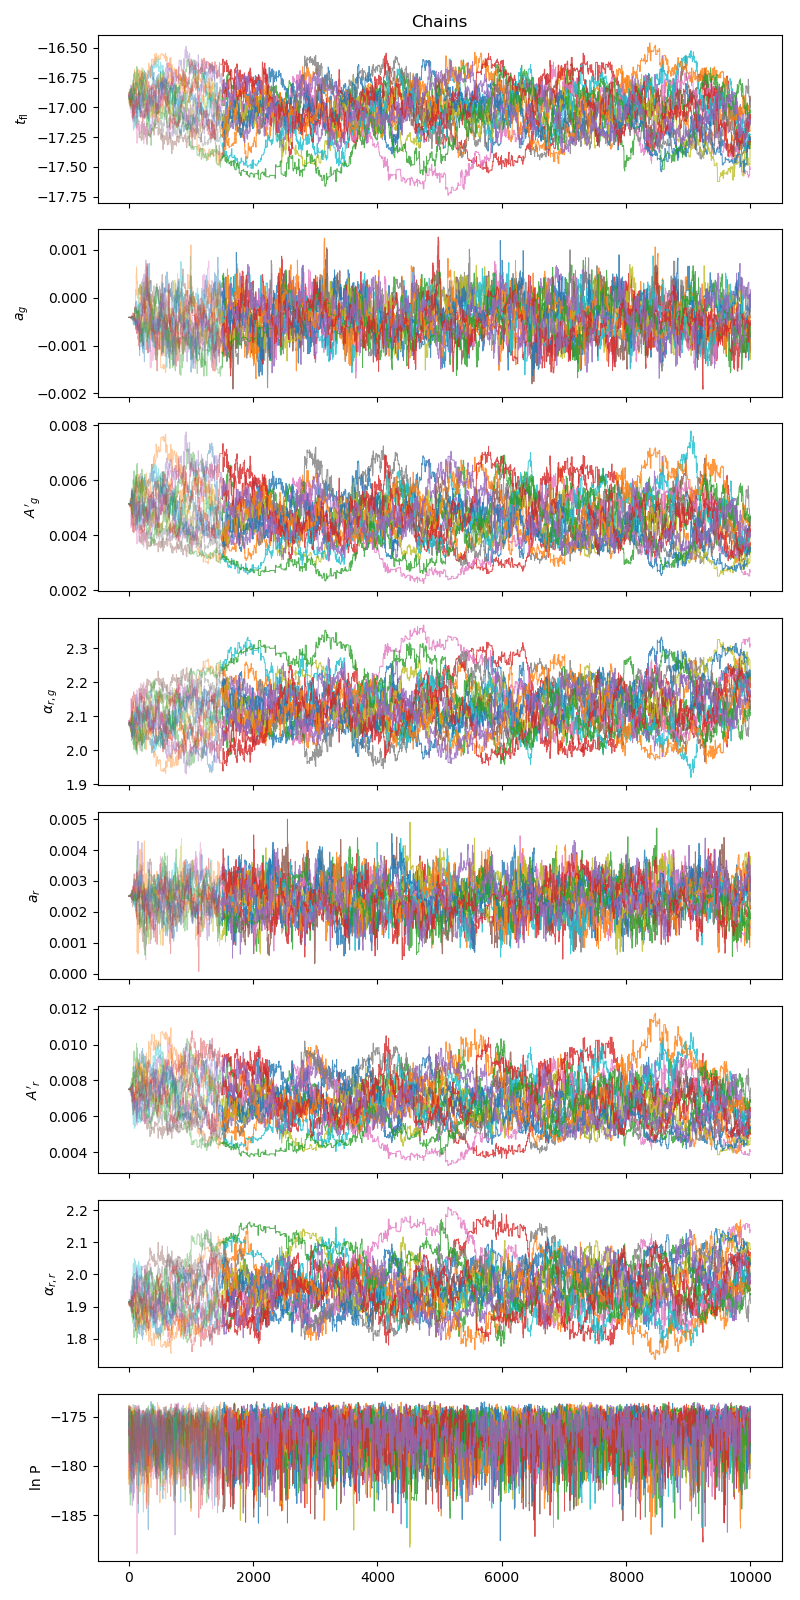

In [31]:
plotChains(sampler, 1500, gr_paramsNames, nplot=15)
plt.tight_layout()

<IPython.core.display.Javascript object>


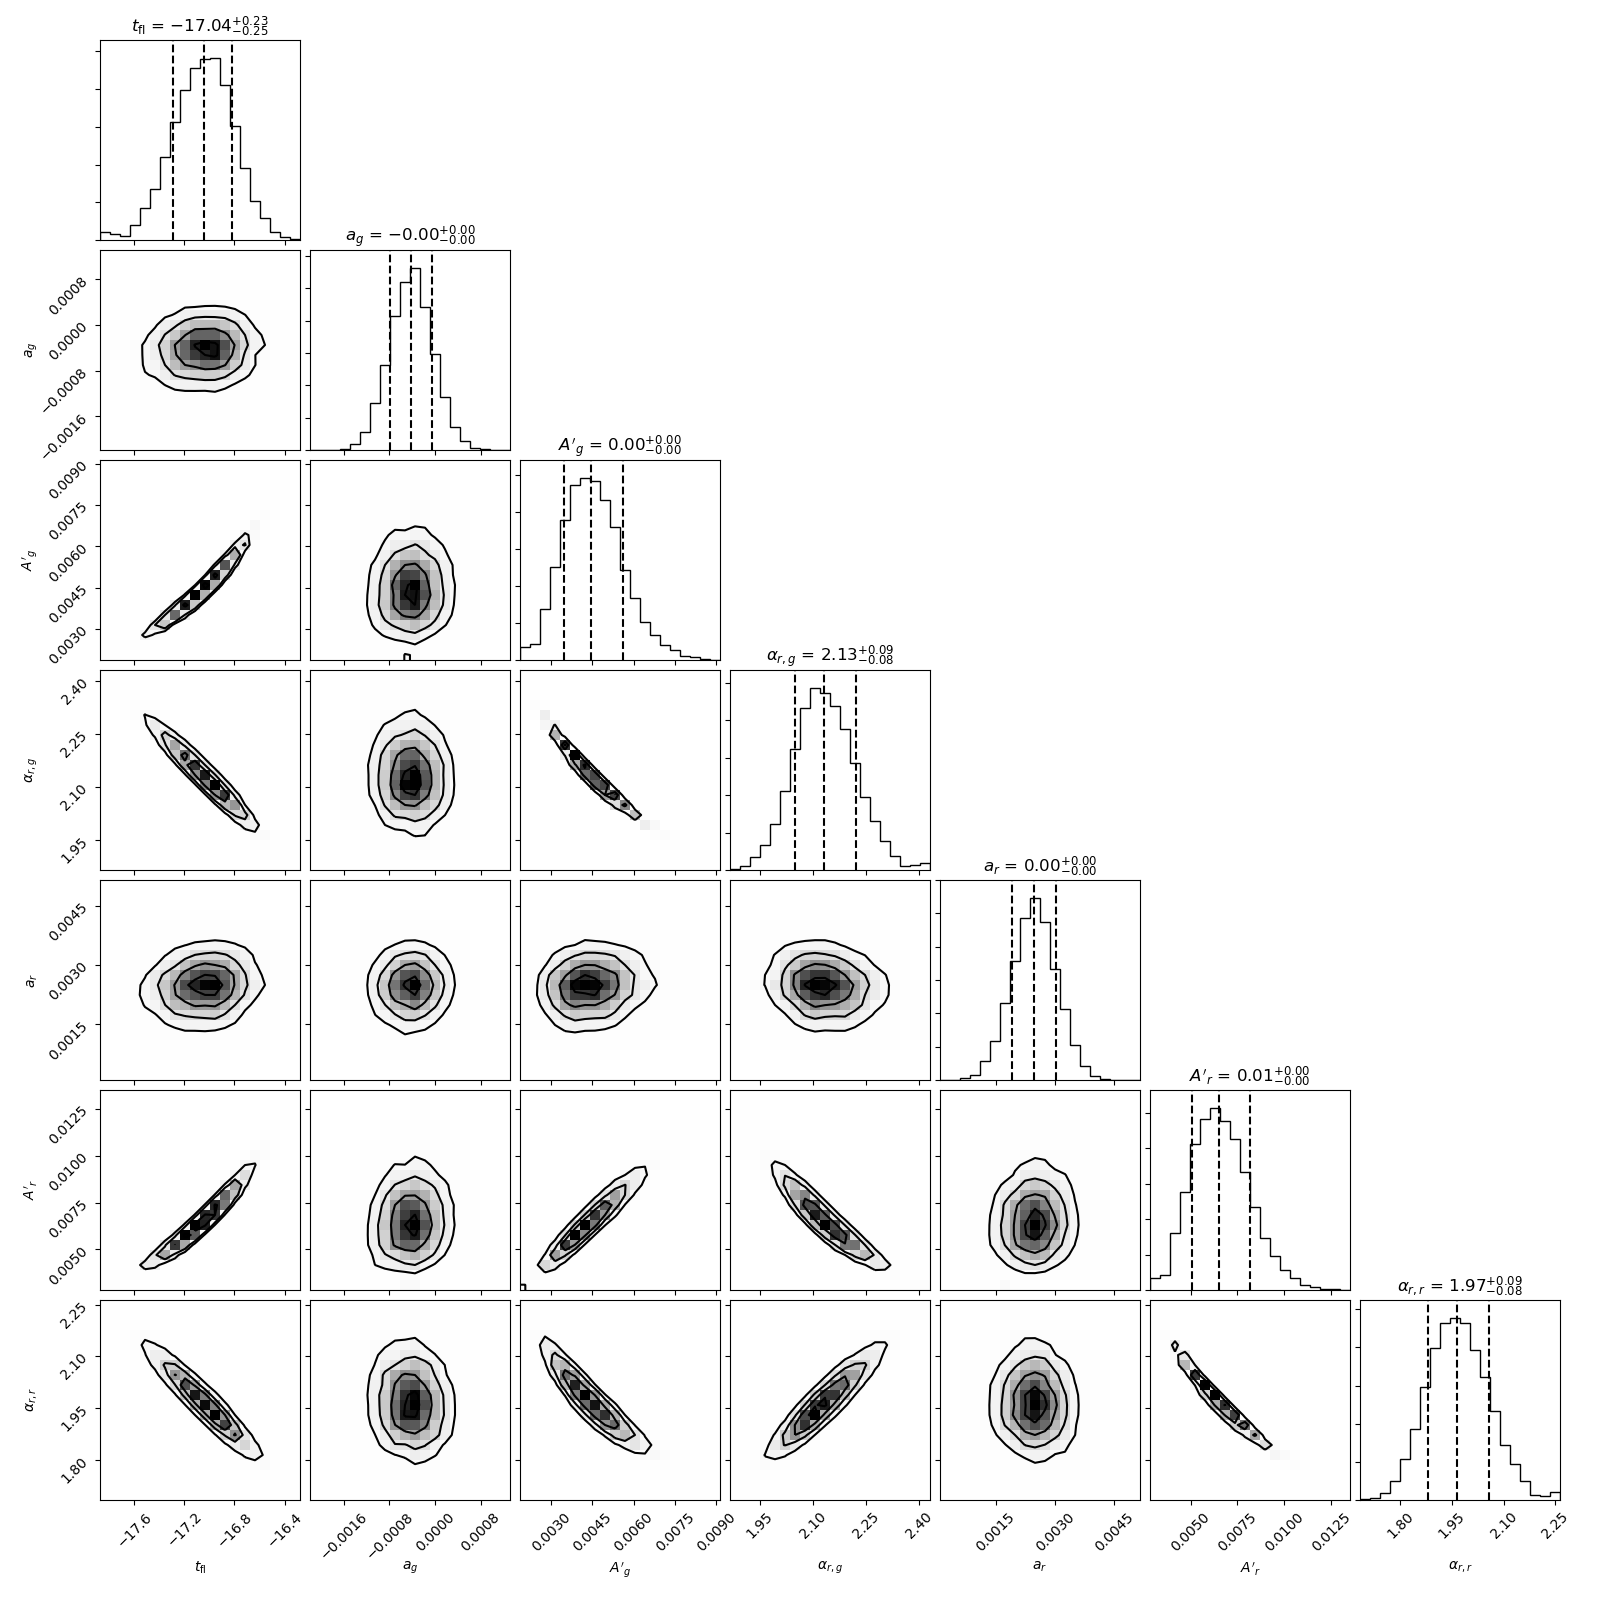

In [32]:
makeCorner(sampler, 2500, gr_paramsNames)

### Notes on parallelization

It appears that using multiple cores does not provide a significant speed up in performance.

Below are some stored results and plots from running on quest with a different number of processors

In [67]:
# while not storing results
ncores = np.array([2, 4, 5, 5, 5, 5, 6, 6, 6, 7, 8, 10, 15, 20, 26])
tot_time = np.array([13993.50, 5192.63, 10233.39, 14400, 14400, 7692.74, 8240.39, 8080.49, 1522.20, 9541.60, 8611.35, 12488.45, 13651.56, 6197.13, 2715.01])
nsteps = np.array([1000000, 500000, 1000000, 516349, 528754, 1000000, 1000000, 1000000, 200000, 1000000, 1000000, 1000000, 1000000, 500000, 200000])
cpu_eff = np.array([87, 74, 70, 53, 53, 73, 66, 68, 64, 65, 65, 61, 40, 33, 21])
mem_use = np.array([6.47, 6.60, 6.85, 3.41, 3.41, 6.67, 6.95, 6.94, 2.07, 7.1, 7.11, 7.39, 8.02, 8.51, 4.41])
mem_eff = np.array([22, 22, 24, 11.65, 11.65, 23, 24, 24, 7, 25, 25, 25, 27, 29, 5])

In [31]:
d_ncores = np.array([3, 4, 6, 8])
d_tot_time = np.array([10699.64, 4964.63, 9989.93, 7693.95])
d_nsteps = np.array([750000, 500000, 1000000, 1000000])
d_cpu_eff = np.array([78, 80, 67, 68])
d_mem_use = np.array([6.94, 7.06, 7.60, 8.15])
d_mem_eff = np.array([24, 24, 26, 28])

In [78]:
# using thin_by = 100
ncores = np.array([3, 4, 5, 6, 7, 8])
tot_time = np.array([10657.04, 12455.27, 9726.25, 6716.09, 10743.65, 10812.20])
nsteps = np.array([900000, 800000, 800000, 500000, 800000, 600000])
cpu_eff = np.array([63, 47, 54, 45, 40, 33])
mem_use = np.array([1, 1, 1, 1, 1, 1])
mem_eff = np.array([2, 2, 3, 3, 3, 4])

In [4]:
# using thin_by = 500
ncores = np.array([2, 3, 4, 5, 6, 7, 8, 10])
tot_time = np.array([1559.88, 1455.93, 1050.50, 965.94, 890.68, 851.89, 991.74, 1488.30])
nsteps = np.array([100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000])
cpu_eff = np.array([81, 61, 63, 64, 62, 59, 57, 59])
mem_use = np.array([1, 1, 1, 1, 1, 1, 1, 1])
mem_eff = np.array([1, 2, 2, 2, 3, 3, 4, 4])

In [74]:
# rerun with no thin_by and no storage
ncores = np.array([2, 3, 4, 5, 6, 7, 8, 12, 16])
tot_time = np.array([2287.98, 1241.54, 1038.46, 894.54, 893.08, 783.83, 1362.39, 1464.66, 2121.96])
nsteps = np.array([100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000])
cpu_eff = np.array([66, 75, 70, 66, 62, 64, 62, 54, 38])
mem_use = np.array([1, 1, 1, 1, 1, 1, 1, 1.5, 2])
mem_eff = np.array([1, 2, 2, 3, 3, 3, 4, 5, 7])

In [16]:
# using thin_by = 500 and ZTF18abxxssh (702 obs)
ncores = np.array([2, 3, 4, 5, 6, 7, 8, 10])
tot_time = np.array([1554.22, 1016.15, 845.92, 794.48, 670.84, 863.17, 983.31, 1179.83])
nsteps = np.array([50000])
cpu_eff = np.array([80, 79, 74, 70, 68, 62, 60, 60])
mem_use = np.array([1, 1, 1, 1, 1, 1, 1, 1])
mem_eff = np.array([1, 2, 2, 2, 3, 3, 4, 4])

In [14]:
# using thin_by = 500 and ZTF18aaqnrum (110 obs)
ncores = np.array([2, 3, 4, 5, 6, 7, 8, 12])
tot_time = np.array([1288.44, 1063.12, 966.28, 747.86, 779.72, 728.91, 859.55, 1290.64])
nsteps = np.array([100000])
cpu_eff = np.array([77, 70, 65, 66, 62, 62, 61, 51])
mem_use = np.array([1, 1, 1, 1, 1, 1, 1, 2])
mem_eff = np.array([1, 2, 2, 2, 3, 3, 4, 5])

In [18]:
# using thin_by = 500 and ZTF18aailmnv (506 obs)
ncores = np.array([2, 3, 4, 5, 6, 7, 8, 12])
tot_time = np.array([2215.58, 1778.02, 1425.01, 1364.36, 1173.55, 1453.12, 1668.66, 2102.35])
nsteps = np.array([100000])
cpu_eff = np.array([87, 78, 76, 69, 67, 62, 61, 55])
mem_use = np.array([1, 1, 1, 1, 1, 1, 1, 2])
mem_eff = np.array([1, 2, 2, 2, 3, 3, 4, 5])

In [ ]:
# using thin_by = 500 
ncores = np.array([])
tot_time = np.array([])
nsteps = np.array([])
cpu_eff = np.array([])
mem_use = np.array([])
mem_eff = np.array([])

<IPython.core.display.Javascript object>


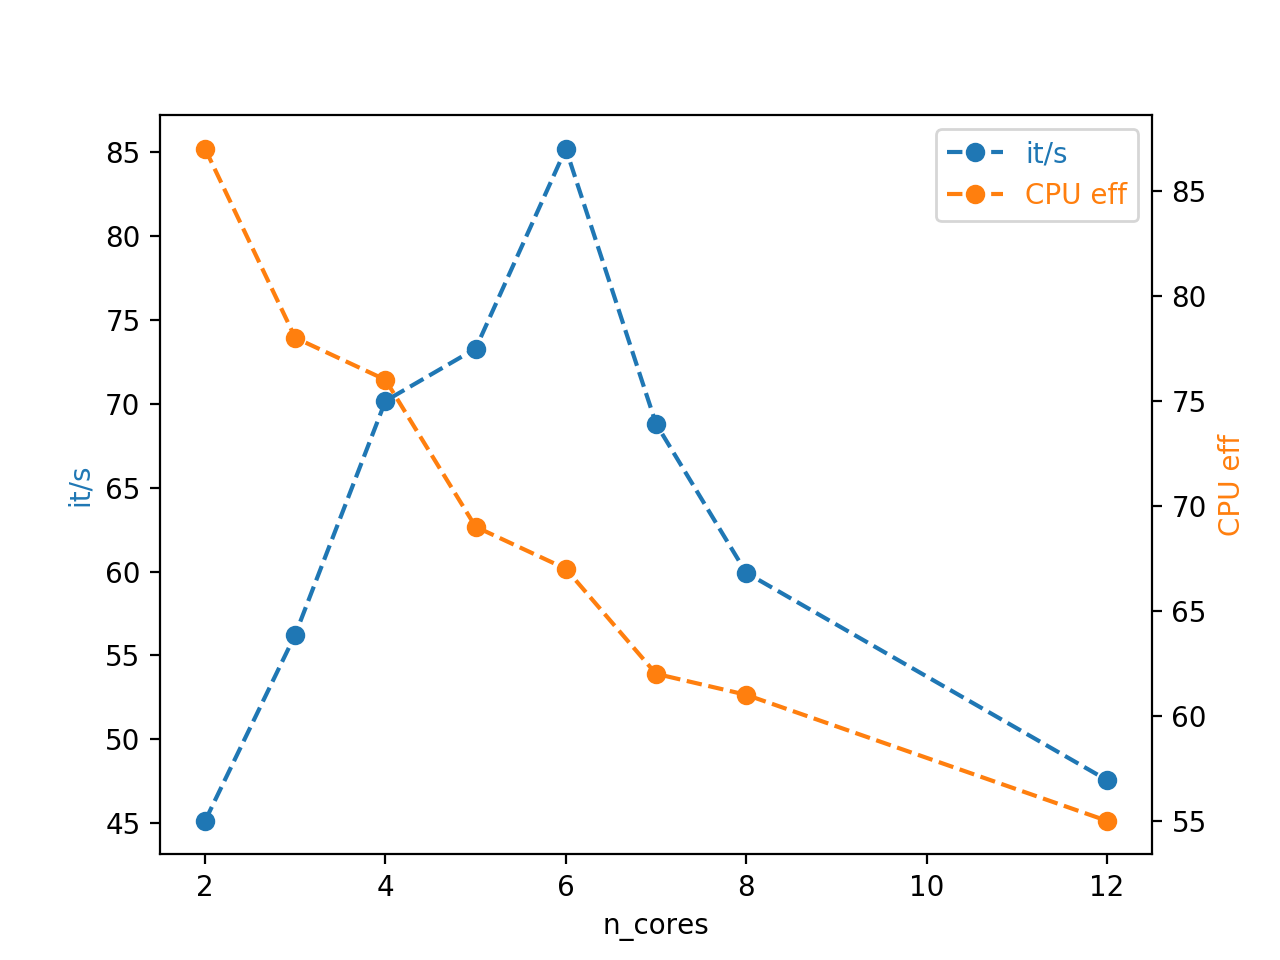

In [19]:
from mpl_toolkits.axes_grid1 import host_subplot
plt.figure()
host = host_subplot(111)

par = host.twinx()

host.set_xlabel("n_cores")
host.set_ylabel("it/s")
par.set_ylabel("CPU eff")

p1, = host.plot(ncores, nsteps/tot_time, 'o--', label="it/s")
p2, = par.plot(ncores, cpu_eff, 'o--', label="CPU eff")
# p1_d, = host.plot(d_ncores, d_nsteps/d_tot_time, 
#                   'd-', c = 'C0', mfc='none', mec='C0', mew=1)
# p1_2, = par.plot(d_ncores, d_cpu_eff, 
#                   'd-', c = 'C1', mfc='none', mec='C1', mew=1)

leg = plt.legend()

host.yaxis.get_label().set_color(p1.get_color())
leg.texts[0].set_color(p1.get_color())

par.yaxis.get_label().set_color(p2.get_color())
leg.texts[1].set_color(p2.get_color())

plt.show()


<IPython.core.display.Javascript object>


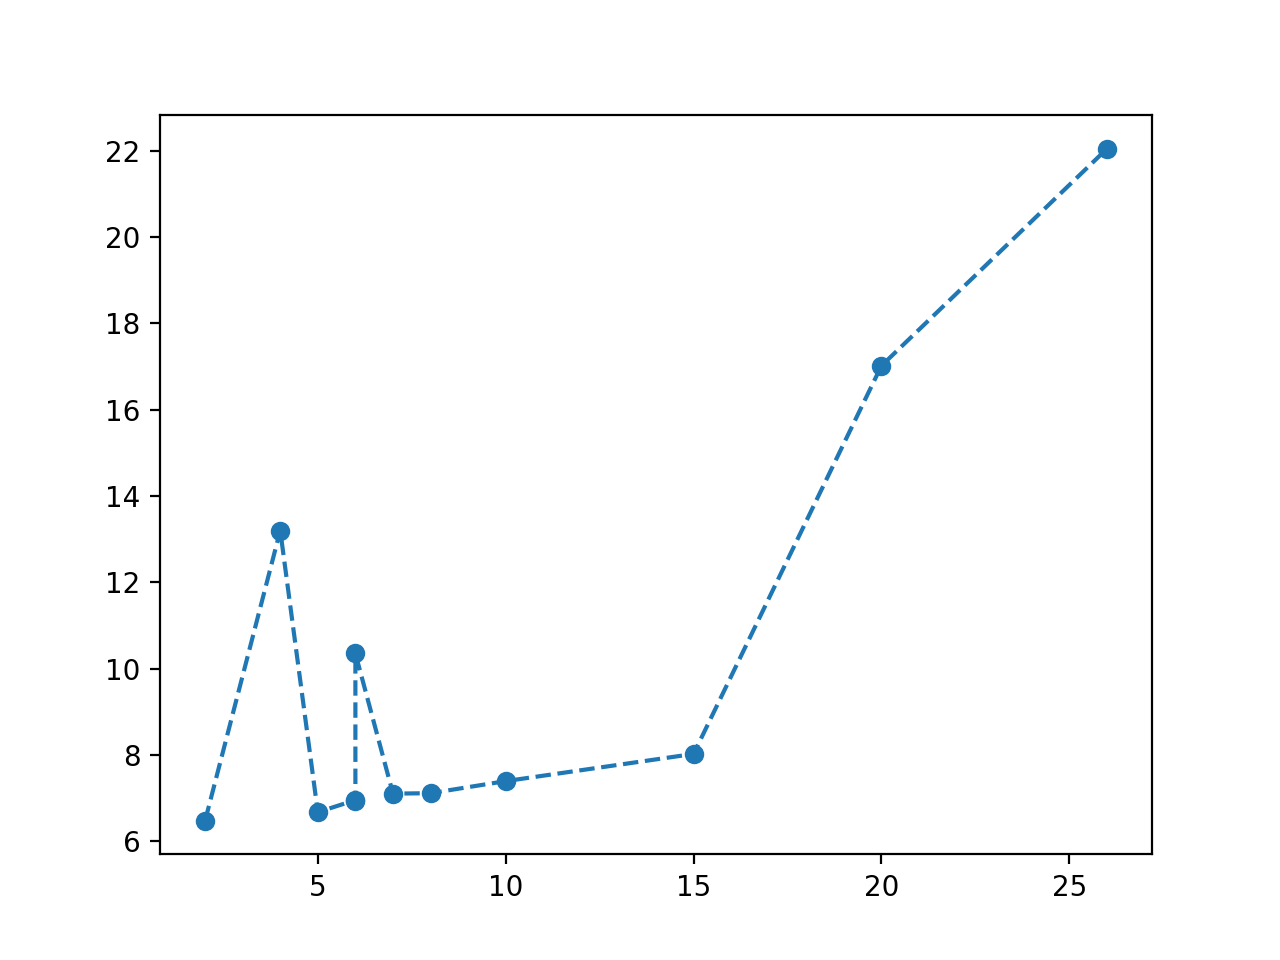

In [70]:
fig, ax = plt.subplots()
ax.plot(ncores, mem_use*1e6/nsteps, 'o--')

In [21]:
#define funtion to make corner plot
def makeCorner(sampler, nburn, paramsNames, quantiles=[0.16, 0.5, 0.84], truths=[]):
    samples = sampler.get_chain(discard=nburn, flat=True)
    if len(truths) > 0:
        f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, 
                          truths=truths, plot_datapoints=False)
    else:
        f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, 
                          show_titles=True, plot_datapoints=False)
    
#define function to plot walker chains  
def plotChains(sampler, nburn, paramsNames, nplot=nwalkers):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams+1,1, figsize = (8,2*(Nparams+1)), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = np.arange(sampler.get_chain().shape[0])

    selected_walkers = np.random.choice(range(sampler.get_chain().shape[1]), nplot, replace=False)
    for i,p in enumerate(paramsNames):
        for w in selected_walkers:
            burn = ax[i].plot(xplot[:nburn], sampler.get_chain()[:nburn,w,i], 
                              alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.get_chain(discard=nburn)[:,w,i], 
                       color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            if i==Nparams-1:
                ax[i+1].plot(xplot[:nburn], sampler.get_log_prob()[:nburn,w], 
                             color=burn[0].get_color(), alpha = 0.4, lw = 0.7, zorder = 1)
                ax[i+1].plot(xplot[nburn:], sampler.get_log_prob(discard=nburn)[:,w], 
                             color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
                ax[i+1].set_ylabel('ln P')
            
    return ax

paramsNames=['$a_g$', '$h_{1,g}$', '$t_{1}$', r'$\alpha_{1,g}$', '$h_{2,g}$', '$t_{2}$', r'$\alpha_{2,g}$']
gr_paramsNames=[r'$t_\mathrm{fl}$', 
             '$a_g$', r"$A'_g$", r'$\alpha_{r, g}$', 
             '$a_r$', r"$A'_r$", r'$\alpha_{r, r}$']
